#### Preprocessing Charging Sessions Dataset

First, we import important libraries needed for the following tasks.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

We import the necessary dataset (charging sessions of EVs) with the data of charging garages in Los Angeles.

In [2]:
data_raw = pd.read_csv("data/charging_sessions.csv")

Getting a first sight of the data by displaying the first 5 observations.

In [3]:
data_raw.head(5)

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [4]:
num_rows, num_columns = data_raw.shape
print(f"rows: {num_rows}, columns: {num_columns}")

rows: 66450, columns: 13


The data in the dataset contains 66.450 observation over 13 different variables. Next, we drop duplicates and have closer look at the different datatypes.

In [5]:
columns = [
    'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered',
    'sessionID', 'siteID', 'spaceID', 'stationID', 'timezone', 'userID', 'userInputs'
]
data_unique = data_raw.drop_duplicates(subset=columns)

In [6]:
dtypes_data = data_unique.dtypes.reset_index()
dtypes_data.columns = ['Row', 'Datetype']
print(dtypes_data)

                 Row Datetype
0         Unnamed: 0    int64
1                 id   object
2     connectionTime   object
3     disconnectTime   object
4   doneChargingTime   object
5       kWhDelivered  float64
6          sessionID   object
7             siteID    int64
8            spaceID   object
9          stationID   object
10          timezone   object
11            userID  float64
12        userInputs   object


We convert all the data into corresponding data types so that we can use them in the further analysis. 
The time-related data is given in the UTC time zone, but the garages are in Los Angeles. In order to obtain accurate information about the timestamps, the data must therefore be converted to the corresponding time zone (LosAngeles).  

In [7]:
data_unique['id'] = data_unique['id'].astype("string")
data_unique['connectionTime'] = pd.to_datetime(data_unique['connectionTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['disconnectTime'] = pd.to_datetime(data_unique['disconnectTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['doneChargingTime'] = pd.to_datetime(data_unique['doneChargingTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['sessionID'] = data_unique['sessionID'].astype("string")
data_unique['siteID'] = data_unique['siteID'].astype("int")
data_unique['spaceID'] = data_unique['spaceID'].astype("string")
data_unique['stationID'] = data_unique['stationID'].astype("string")
data_unique['timezone'] = data_unique['timezone'].astype("string")
data_unique['userID'] = data_unique['userID'].astype("string")
data_unique['sessionID'] = data_unique['sessionID'].astype("string")
data_unique['userInputs'] = data_unique['userInputs'].apply(lambda x: list(x) if isinstance(x, list) else [x])

The `unnamed` column is presumably an index from the riginal DataFrame and gets transferred into a column when reading the CSV-file. Since our data contains a unique ID for each entry, the unnamed-numbering is not needed and can be deleted.

In [8]:
data_unique = data_unique.drop('Unnamed: 0', axis=1)

print(data_unique.dtypes)

id                  string[python]
connectionTime      datetime64[ns]
disconnectTime      datetime64[ns]
doneChargingTime    datetime64[ns]
kWhDelivered               float64
sessionID           string[python]
siteID                       int64
spaceID             string[python]
stationID           string[python]
timezone            string[python]
userID              string[python]
userInputs                  object
dtype: object


In the dataset, entries were identified where doneChargingTime exceeds disconnectTime. As the time difference in most cases is less than one minute, we assume a delayed timestamp for doneChargingTime. Therefore, we set doneChargingTime equal to disconnectTime wherever it exceeds the latter.

In [9]:
# Set doneChargingTime to disconnectTime if doneChargingTime is greater than disconnectTime
data_unique.loc[data_unique['doneChargingTime'] > data_unique['disconnectTime'], 'doneChargingTime'] = data_unique['disconnectTime']

In [10]:
print(data_unique.info())

<class 'pandas.core.frame.DataFrame'>
Index: 65037 entries, 0 to 65036
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                65037 non-null  string        
 1   connectionTime    65037 non-null  datetime64[ns]
 2   disconnectTime    65037 non-null  datetime64[ns]
 3   doneChargingTime  60950 non-null  datetime64[ns]
 4   kWhDelivered      65037 non-null  float64       
 5   sessionID         65037 non-null  string        
 6   siteID            65037 non-null  int64         
 7   spaceID           65037 non-null  string        
 8   stationID         65037 non-null  string        
 9   timezone          65037 non-null  string        
 10  userID            47822 non-null  string        
 11  userInputs        65037 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(1), object(1), string(6)
memory usage: 8.5+ MB
None


In [11]:
missing_values_count = data_unique.isnull().sum()
print(missing_values_count)

id                      0
connectionTime          0
disconnectTime          0
doneChargingTime     4087
kWhDelivered            0
sessionID               0
siteID                  0
spaceID                 0
stationID               0
timezone                0
userID              17215
userInputs              0
dtype: int64


By looking at the dataframe, you can see that `doneChargingTime` and `userID` have missing values.  

The missing values in userID can be explained by the fact that not every garage user is registered; therefore, some accounts are naturally absent. However, the missing entries in `doneChargingTime` appear unusual.

In [12]:
# create Table with missing values in doneChargingTimeb
miss_doneChargingTime = data_unique[data_unique['doneChargingTime'].isna()]
miss_doneChargingTime.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
3756,5ea3848df9af8b428bf97225,2020-04-08 09:36:53,2020-04-08 20:43:29,NaT,25.183,1_1_194_822_2020-04-08 16:36:53.316264,1,AG-1F12,1-1-194-822,America/Los_Angeles,507.0,"[[{'WhPerMile': 250, 'kWhRequested': 75.0, 'mi..."
3757,5ea4d60df9af8b46573f1ee7,2020-04-09 06:23:52,2020-04-09 10:59:02,NaT,14.136,1_1_193_827_2020-04-09 13:23:51.689520,1,AG-1F02,1-1-193-827,America/Los_Angeles,419.0,"[[{'WhPerMile': 400, 'kWhRequested': 40.0, 'mi..."
3758,5ea4d60df9af8b46573f1ee8,2020-04-09 06:40:03,2020-04-09 14:43:22,NaT,14.203,1_1_178_823_2020-04-09 13:39:55.115497,1,AG-1F08,1-1-178-823,America/Los_Angeles,5065.0,"[[{'WhPerMile': 400, 'kWhRequested': 24.0, 'mi..."
3759,5ea4d60df9af8b46573f1ee9,2020-04-09 07:01:53,2020-04-09 09:33:40,NaT,13.041,1_1_178_828_2020-04-09 14:01:53.467693,1,AG-1F10,1-1-178-828,America/Los_Angeles,651.0,"[[{'WhPerMile': 400, 'kWhRequested': 20.0, 'mi..."
3760,5ea4d60df9af8b46573f1eea,2020-04-09 08:01:06,2020-04-09 16:38:08,NaT,5.797,1_1_193_820_2020-04-09 15:01:06.343454,1,AG-1F04,1-1-193-820,America/Los_Angeles,466.0,"[[{'WhPerMile': 300, 'kWhRequested': 6.0, 'mil..."


Upon closer analysis of the missing entries for the charging time (`miss_doneChargingTime`), we found that all of them have normal values for the attribute `kWhDelivered`, indicating that current flow was indeed present.

(Removing this data from the dataframe would imply that the charging stations were free at those times, which is inaccurate and would skew predictions. Therefore, we decided to retain this data for now and, if necessary, exclude it during model training and predictions about parking space utilization after charging is complete.)

We calculate the the percentage of missing (NaN) values for each column.

In [13]:
data_unique.isnull().mean() * 100

id                   0.000000
connectionTime       0.000000
disconnectTime       0.000000
doneChargingTime     6.284115
kWhDelivered         0.000000
sessionID            0.000000
siteID               0.000000
spaceID              0.000000
stationID            0.000000
timezone             0.000000
userID              26.469548
userInputs           0.000000
dtype: float64

Let's calculate the percentage of data left after removing the missing values.

In [14]:
len(data_unique['doneChargingTime'].dropna())/len(data_unique['doneChargingTime']) * 100

93.71588480403462

After removing the columns with missing values, around 94% of the data is still intact which seems to be sufficient. So we first create a copy of the data set in order to then remove the missing values from ‘doneChargingTime’.

In [15]:
# Create a copy of the data before dropping NA values from doneChaargingTime
data_with_NA = data_unique.copy()

# Drop NA from doneChargingTime
data_unique.dropna(subset=['doneChargingTime'], inplace=True)

print(data_unique['doneChargingTime'].isnull().sum())

0


We can explore how the data is distributed in each column before and after removing null values by plotting histograms. This approach will enable us to compare the distribution trends in both scenarios.

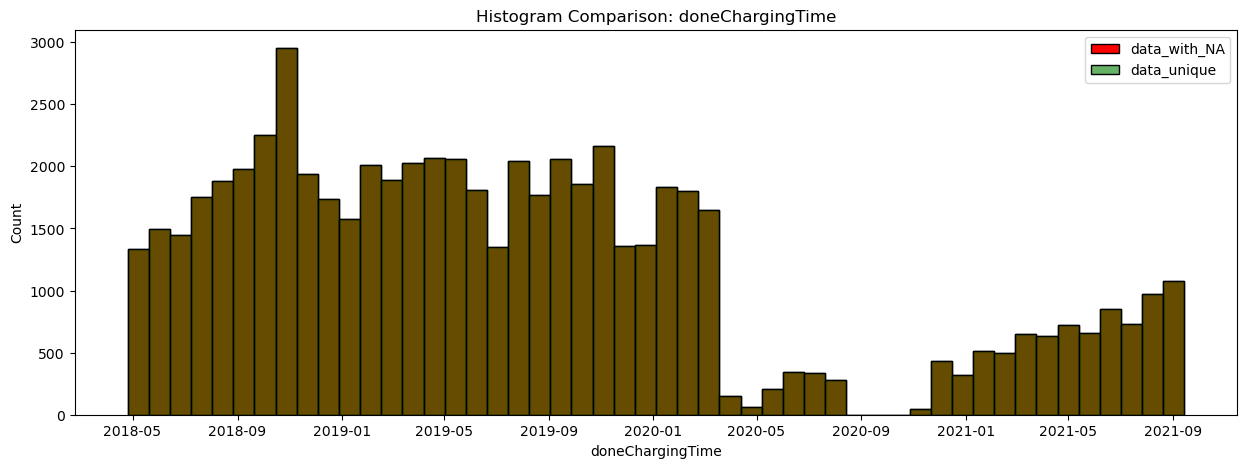

In [16]:
plt.figure(figsize=(15, 5))

# Histogram: Data with doneChargingTime NaT values
sns.histplot(data=data_with_NA, x='doneChargingTime', bins=50, color='red', alpha=1, kde=False, label='data_with_NA')

# Histogram: Data with removed doneChargingTime NaT values
sns.histplot(data=data_unique, x='doneChargingTime', bins=50, color='green', alpha=0.6, kde=False, label='data_unique')

plt.legend()

plt.title('Histogram Comparison: doneChargingTime')
plt.xlabel('doneChargingTime')
plt.ylabel('Count')

plt.show()


By comparing the histograms of the 'doneChargingTime' column before and after removing the null values, it is clear that the data distribution stays consistent. The overlapping histograms show that there is no major change in the distribution pattern after null values were removed.

In [17]:
filtered_data = data_unique[data_unique['doneChargingTime'] > data_unique['disconnectTime']]

filtered_data['time_difference'] = (filtered_data['doneChargingTime'] - filtered_data['disconnectTime']).dt.total_seconds()

average_difference = filtered_data['time_difference'].mean()

average_kwh_delivered = filtered_data['kWhDelivered'].mean()

other_cases = data_unique[data_unique['doneChargingTime'] <= data_unique['disconnectTime']]

average_kwh_delivered_other = other_cases['kWhDelivered'].mean()

print(f"Average Difference: {average_difference:.2f} seconds")
print(f"Average kWh (doneChargingTime > disconnectTime): {average_kwh_delivered:.2f} kWh")
print(f"Average kWh (doneChargingTime <= disconnectTime): {average_kwh_delivered_other:.2f} kWh")

Average Difference: nan seconds
Average kWh (doneChargingTime > disconnectTime): nan kWh
Average kWh (doneChargingTime <= disconnectTime): 11.58 kWh


In [18]:
filtered_data.head(10)

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,time_difference


#### Outlier Detection

This analysis focuses on detecting outliers in the kWhDelivered column. We start by examining the statistical summary to understand the data distribution.

In [19]:
data_unique.describe()[['kWhDelivered']]

,kWhDelivered
count,60950.000000
mean,11.583268
min,0.501000
25%,5.013000
50%,8.991000
75%,13.984000
max,108.797242
std,10.153601


Although the mean is relatively sensitive to outliers, the mean of kWhDelivered is 11.58 while the maximum is 108.8. This shows that the maximum is an outlier. We make use of a boxplot and a histogram to visually summarize the distribution and identify potential outliers.

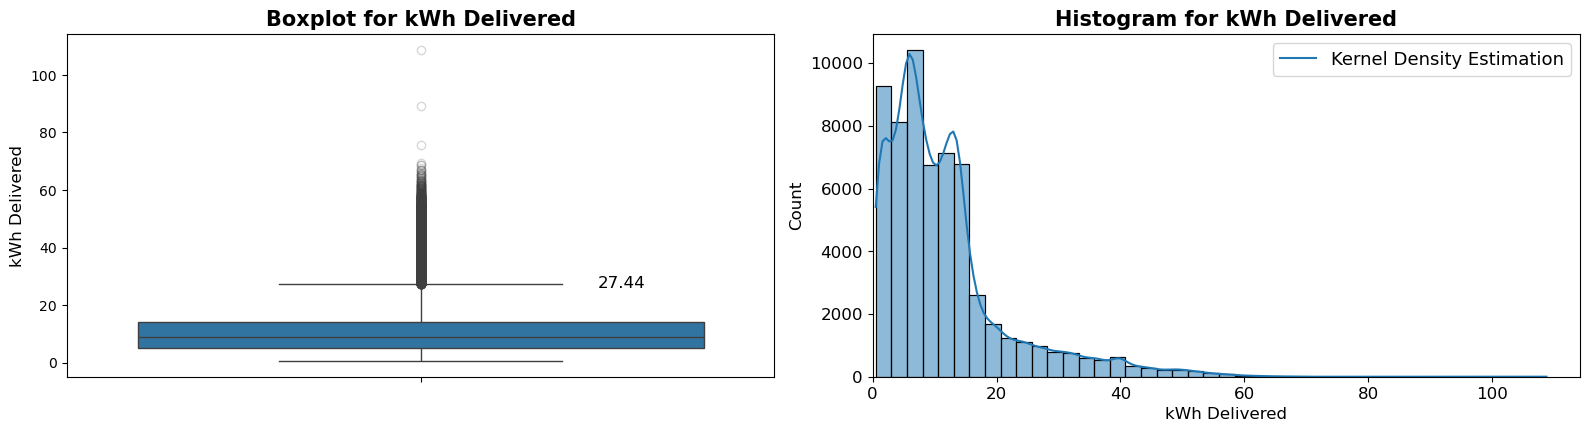

In [20]:
plt.figure(figsize=(16, 8))

q1 = data_unique['kWhDelivered'].quantile(0.25)
q3 = data_unique['kWhDelivered'].quantile(0.75)
iqr = q3 - q1
upper_whisker = q3 + 1.5 * iqr

# Boxplot
plt.subplot(2, 2, 1)
sns.boxplot(data=data_unique, y='kWhDelivered', flierprops={'alpha': 0.2})
plt.title("Boxplot for kWh Delivered", fontsize=15, fontweight='bold')
plt.ylabel("kWh Delivered", fontsize=12)
plt.xlabel("")
plt.text(0.25, upper_whisker, f"{upper_whisker:.2f}", 
         ha='left', va='center', fontsize=12, color='black')

# Histogram
plt.subplot(2, 2, 2)
sns.histplot(data_unique['kWhDelivered'], kde=True, binwidth=2.5)
plt.title("Histogram for kWh Delivered", fontsize=15, fontweight='bold')
plt.xlabel("kWh Delivered", fontsize=12)
plt.ylabel("Count", fontsize=12) 
plt.legend(labels=["Kernel Density Estimation"], fontsize=13)

plt.xlim(left=0)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

Based on the two visualizations, it is evident that the majority of the values are quite low. The upper whisker of the boxplot is at 27.44, meaning it represents the largest value in the dataset that is less than or equal to Q3 + 1.5 * IQR. Values above this threshold are considered outliers. These become more frequent up to approximately 60. Only three observations fall between 75 and 110. The distribution is highly positively right skewed.

The following function calculates the IQR to detect outliers above the upper whisker.

In [21]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   iqr=q3-q1

   outliers = df[((df<(q1-1.5*iqr)) | (df>(q3+1.5*iqr)))]

   return outliers

In [22]:
outliers = find_outliers_IQR(data_unique['kWhDelivered'])

print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min outlier value: "+ str(outliers.min()))

outliers

number of outliers: 5168
max outlier value: 108.79724166666666
min outlier value: 27.442


1        33.097
6        43.477
7        32.441
13       39.806
21       49.874
          ...  
65003    32.334
65005    30.030
65008    35.007
65024    30.198
65029    41.047
Name: kWhDelivered, Length: 5168, dtype: float64

The summary indicates that there are 5,168 outliers. The lowest outlier value is 27.44, as previously mentioned, while the maximum is 108.8.

In [23]:
data_unique[data_unique['kWhDelivered'] > 70]

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
18641,610c829df9af8b0580e98730,2021-07-20 15:16:54,2021-07-21 08:18:03,2021-07-21 08:18:03,108.797242,1_1_193_829_2021-07-20 18:27:33.500144,1,AG-1F03,1-1-193-829,America/Los_Angeles,378.0,"[[{'WhPerMile': 258, 'kWhRequested': 35.088, '..."
18643,610c829df9af8b0580e98732,2021-07-20 15:16:56,2021-07-21 08:18:16,2021-07-21 08:18:16,89.362732,1_1_194_818_2021-07-20 13:54:47.875453,1,AG-1F14,1-1-194-818,America/Los_Angeles,481.0,"[[{'WhPerMile': 360, 'kWhRequested': 86.4, 'mi..."
20986,5c60d02df9af8b149d7da395,2019-01-25 19:40:20,2019-01-26 14:36:03,2019-01-26 06:45:12,75.528000,2_39_91_437_2019-01-26 03:40:20.383123,2,CA-317,2-39-91-437,America/Los_Angeles,1225.0,"[[{'WhPerMile': 600, 'kWhRequested': 180.0, 'm..."


The high kWhDelivered values are rare but appear to be realistic given the long charging durations.

The following function replaces the outlier values that exceed the given upper limit with the median value of 'kWhDelivered'.

In [24]:
def cap_outliers(df, column, upper_limit):

    median = df[column].median()
    print(f"Median: {median}")

    upper_limit = upper_limit
    print(f"Upper limit: {upper_limit}")

    df[column] = np.where(
        df[column] > upper_limit,
        median,
        df[column]
    )
    return df


In [25]:
data_unique = cap_outliers(data_unique, 'kWhDelivered', 27)

Median: 8.991
Upper limit: 27


Replotting the resulting distribution after capping the outliers at 27.

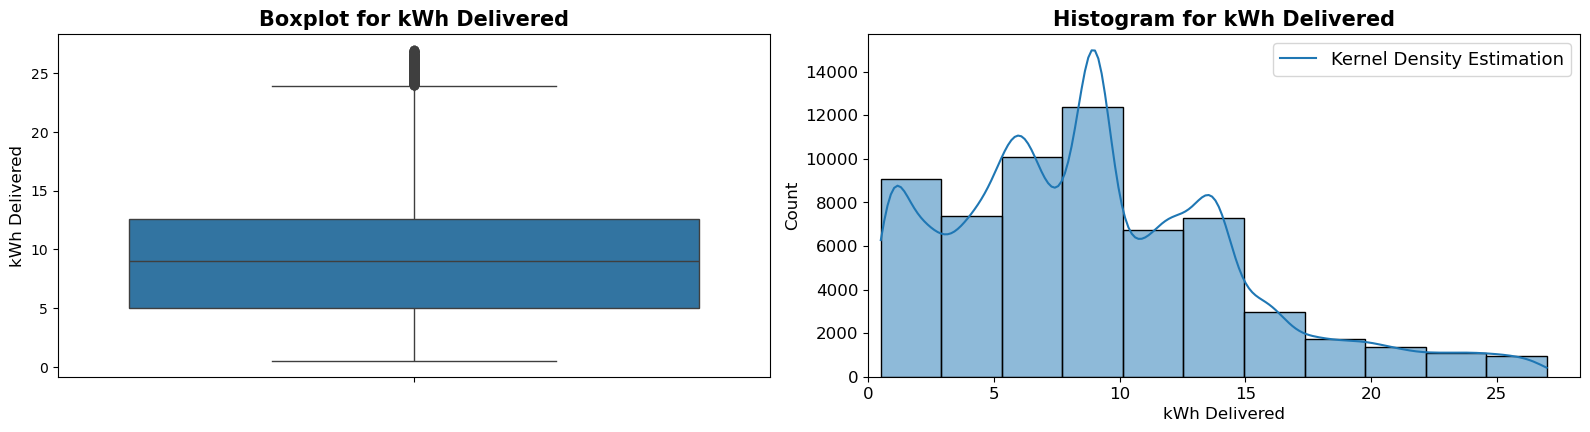

In [26]:
plt.figure(figsize=(16, 8))

# Boxplot
plt.subplot(2, 2, 1)
sns.boxplot(data=data_unique, y='kWhDelivered', flierprops={'alpha': 0.1})
plt.title("Boxplot for kWh Delivered", fontsize=15, fontweight='bold')
plt.ylabel("kWh Delivered", fontsize=12)
plt.xlabel("") 

# Histogram
plt.subplot(2, 2, 2)
sns.histplot(data_unique['kWhDelivered'], kde=True, binwidth=2.5)
plt.title("Histogram for kWh Delivered", fontsize=15, fontweight='bold')
plt.xlabel("kWh Delivered", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(labels=["Kernel Density Estimation"], fontsize=13)

plt.xlim(left=0)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

By capping the outliers at the upper whisker to the median, the distribution becomes more stable and less influenced by extreme values. The values concentrate more closely around the median, making the distribution more compact.

#### Extracting "userInputs" into a Separate Table

Process the column userInputs to ensure each entry is JSON-formatted and interpretable as a Python dictionary.

In [27]:
import json

data_unique['userInputs'] = data_unique['userInputs'].astype("string")

def format_user_input(entry):
    try:
        entry = entry[2:-2]
        entry = entry.replace("'", "\"").replace("True", "true").replace("False", "false")  
        return json.loads(entry)  
    except json.JSONDecodeError:
        return None  


data_unique['userInputs']= data_unique['userInputs'].apply(format_user_input)

This code extracts the contents of the userInputs column into a separate table for better clarity and organization of data. By splitting out userInputs, each nested entry can be analyzed individually, providing a more detailed view of the information stored within. This approach makes it easier to work with and understand the data structure, especially when userInputs contains multiple key-value pairs or complex JSON objects. By creating a dedicated table, each entry can be accessed, processed, and filtered independently, enhancing data readability and simplifying further analysis.

In [28]:
# Split nested lists in 'userInputs' into separate rows, resetting index for a clean DataFrame.
data_unique_splitted = data_unique.explode('userInputs', ignore_index=True)

# Select only specific columns 'id', 'userID', and 'userInputs' from the exploded DataFrame.
userInputs_data = data_unique_splitted[['id', 'userID', 'userInputs']]

# Rename the 'id' column to 'data_unique_id' for clarity.
userInputs_data = userInputs_data.rename(columns={'id': 'data_unique_id'})

# Add a new column 'id' with a unique sequential identifier for each row.
userInputs_data['id'] = range(1, len(userInputs_data) + 1)

# Expand the JSON data in 'userInputs' column to separate columns for each key-value pair.
userInputs_expanded = pd.json_normalize(userInputs_data['userInputs'])

# Concatenate the expanded data with the original DataFrame along columns (side by side).
userInputs_data = pd.concat([userInputs_data, userInputs_expanded], axis=1)

# Drop the original 'userInputs' column as it's no longer needed after expanding.
userInputs_data = userInputs_data.drop('userInputs', axis=1)

# Remove rows with missing values in critical columns 'userID', 'WhPerMile', and 'kWhRequested'.
userInputs_data = userInputs_data.dropna(subset=['userID', 'WhPerMile', 'kWhRequested'])

# Convert 'paymentRequired' column to a boolean type for correct data interpretation.
userInputs_data['paymentRequired'] = userInputs_data['paymentRequired'].astype(bool)

# Modify 'modifiedAt' column: extract only the date and time, convert to datetime in UTC, and localize to LA time.
userInputs_data['modifiedAt'] = userInputs_data['modifiedAt'].apply(
    lambda x: x.split(", ")[1].replace(" GMT", "") if isinstance(x, str) else x
)
userInputs_data['modifiedAt'] = pd.to_datetime(userInputs_data['modifiedAt'], format="%d %b %Y %H:%M:%S", utc=True, errors='coerce')
userInputs_data['modifiedAt'] = userInputs_data['modifiedAt'].dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)

# Modify 'requestedDeparture' column: extract only the date and time, convert to datetime in UTC, and localize to LA time.
userInputs_data['requestedDeparture'] = userInputs_data['requestedDeparture'].apply(
    lambda x: x.split(", ")[1].replace(" GMT", "") if isinstance(x, str) else x
)
userInputs_data['requestedDeparture'] = pd.to_datetime(userInputs_data['requestedDeparture'], format="%d %b %Y %H:%M:%S", utc=True, errors='coerce')
userInputs_data['requestedDeparture'] = userInputs_data['requestedDeparture'].dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)

#  drop userInputs in data_unique table since its not needed anymore
data_unique = data_unique.drop('userInputs', axis=1)


In [29]:
# split the dataset in two different. One for the station with siteID 1 and one for the station with the siteID 2 for further analysis
data_1 = data_unique[data_unique['siteID']==1]
data_2 = data_unique[data_unique['siteID']==2]

#### Preprocessing Weather Burbank Dataset

The weather dataset is also imported and duplicates are removed. Although there are none, we have carried out this step to be on the safe side.  
The data was converted to the corresponding data types and the time was adjusted to the los-angeles time zone again.  
There is some missing data in this data set for the `temperature` and the `cloud_cover`. However, these are difficult to reproduce and are therefore deleted from the data set.

In [30]:
weather_raw=pd.read_csv("data/weather_burbank_airport.csv")

# delete duplicates
columns = [
    'city', 'timestamp', 'temperature', 'cloud_cover',
    'cloud_cover_description', 'pressure', 'windspeed', 'precipitation', 'felt_temperature'
]
weather_unique = weather_raw.drop_duplicates(subset=columns)

#Transform to correct Data Types
weather_unique['city']=weather_raw['city'].astype('string')
weather_unique['timestamp'] = pd.to_datetime(weather_raw['timestamp'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
weather_unique['cloud_cover_description']=weather_raw['cloud_cover_description'].astype('string')

# drop with missing values
weather_unique = weather_unique.dropna(subset=['temperature'])
weather_unique = weather_unique.dropna(subset=['cloud_cover'])

print(weather_unique.dtypes)

city                       string[python]
timestamp                  datetime64[ns]
temperature                       float64
cloud_cover                       float64
cloud_cover_description    string[python]
pressure                          float64
windspeed                         float64
precipitation                     float64
felt_temperature                  float64
dtype: object


# 2. Descriptive Analytics

### a) Temporal patterns and Seasonality

We will begin by analyzing the temporal patterns and seasonality of charging events. This analysis will focus on understanding how charging behavior evolves over time and identifying any recurring seasonal trends. Our goal is to uncover initial patterns and propose possible hypotheses to explain these phenomena.

It is important to note that a charging event is primarily considered as the duration from the connection time to the disconnection time. However, we will also examine the perspective where the event is measured from the connection time to the "done charging" time.

#### Daily patterns

Histogram of charging sessions throughout the day, broken down by each hour of the day. The calculation spans from the connection time to the disconnection time.

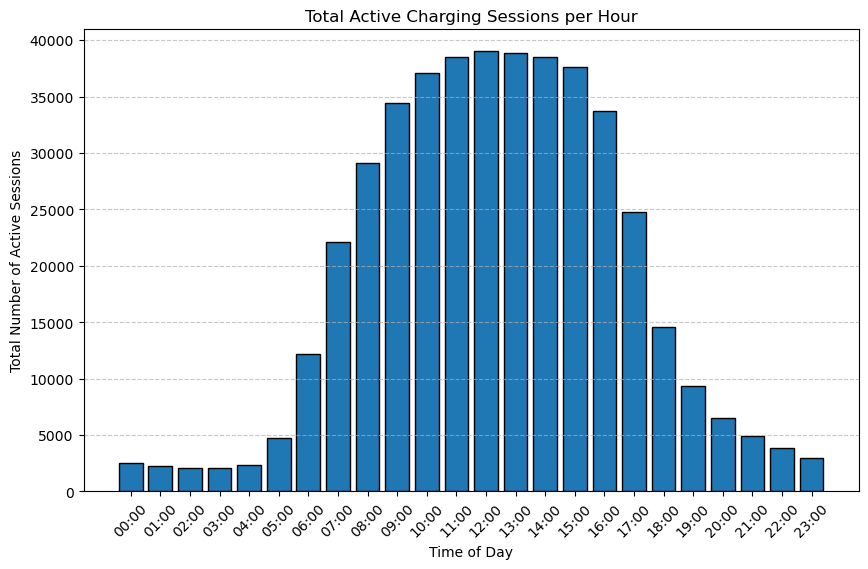

In [31]:
# Initialize an array to store the number of active charging sessions for each hour
active_sessions_by_hour = np.zeros(24)

# Loop through each row to calculate active sessions for each hour
for index, row in data_unique.iterrows():
    # Extract the start and end hours of the charging session
    start_hour = row['connectionTime'].hour
    end_hour = row['disconnectTime'].hour

    # Handle sessions that span across midnight
    if row['disconnectTime'].date() > row['connectionTime'].date():
        end_hour += 24  # Extend the end hour beyond midnight

    # Increment the active sessions for each hour within the session's range
    for hour in range(start_hour, end_hour + 1):
        active_sessions_by_hour[hour % 24] += 1  # %24 to wrap around to 0–23 hours

# Create time labels for the x-axis in "HH:00" format
time_labels = [f"{hour:02d}:00" for hour in range(24)]

# Visualization: Histogram of total active charging sessions per hour
plt.figure(figsize=(10, 6))
plt.bar(range(24), active_sessions_by_hour, tick_label=time_labels, width=0.8, edgecolor="black")
plt.title('Total Active Charging Sessions per Hour')
plt.xlabel('Time of Day')
plt.ylabel('Total Number of Active Sessions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for the y-axis
plt.ticklabel_format(style='plain', axis='y')  # Ensure plain format for y-axis
plt.show()

Histogram of the actual charging process required to fully charge a vehicle throughout the day, broken down by each hour of the day. The calculation spans from the connection time to the done charging time.

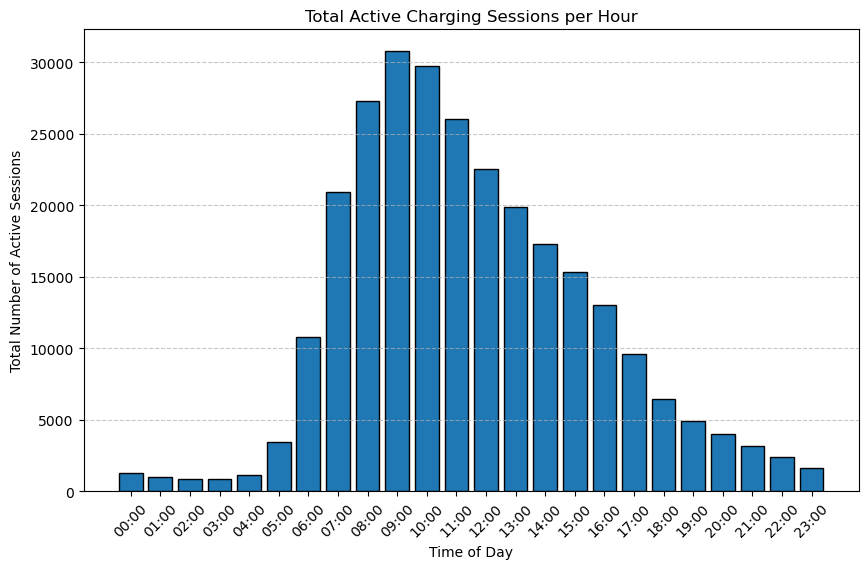

In [32]:
# Initialize an array to store the number of active charging sessions for each hour
active_sessions_by_hour = np.zeros(24)

# Loop through each row to calculate active sessions for each hour
for index, row in data_unique.iterrows():
    # Extract the start and end hours of the charging session
    start_hour = row['connectionTime'].hour
    end_hour = row['doneChargingTime'].hour

    # Handle sessions that span across midnight
    if row['doneChargingTime'].date() > row['connectionTime'].date():
        end_hour += 24  # Extend the end hour beyond midnight

    # Increment the active sessions for each hour within the session's range
    for hour in range(start_hour, end_hour + 1):
        active_sessions_by_hour[hour % 24] += 1  # %24 to wrap around to 0–23 hours

# Create time labels for the x-axis in "HH:00" format
time_labels = [f"{hour:02d}:00" for hour in range(24)]

# Visualization: Histogram of total active charging sessions per hour
plt.figure(figsize=(10, 6))
plt.bar(range(24), active_sessions_by_hour, tick_label=time_labels, width=0.8, edgecolor="black")
plt.title('Total Active Charging Sessions per Hour')
plt.xlabel('Time of Day')
plt.ylabel('Total Number of Active Sessions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for the y-axis
plt.ticklabel_format(style='plain', axis='y')  # Ensure plain format for y-axis
plt.show()

Histogram of connection times throughout the day, categorized by each hour of the day.

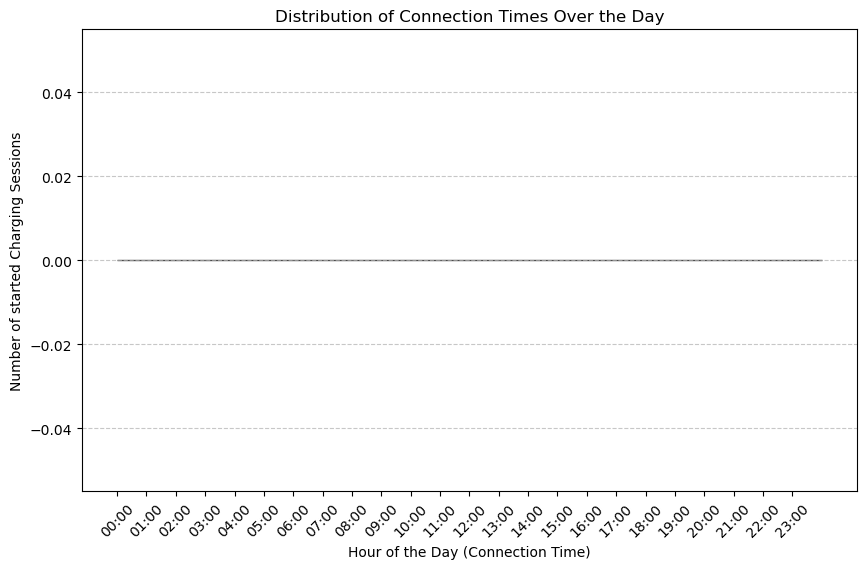

In [33]:
# Plot a histogram to show the distribution of connection times over the day
plt.figure(figsize=(10, 6))
plt.hist(data_unique['connectionTime'], bins=24, range=(0, 24), edgecolor='black', alpha=0.7)
plt.title('Distribution of Connection Times Over the Day')
plt.xlabel('Hour of the Day (Connection Time)')
plt.ylabel('Number of started Charging Sessions')
plt.xticks(range(24), [f"{hour:02d}:00" for hour in range(24)], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Histogram of the disconnection times and done charging times throughout the day, categorized by each hour of the day.

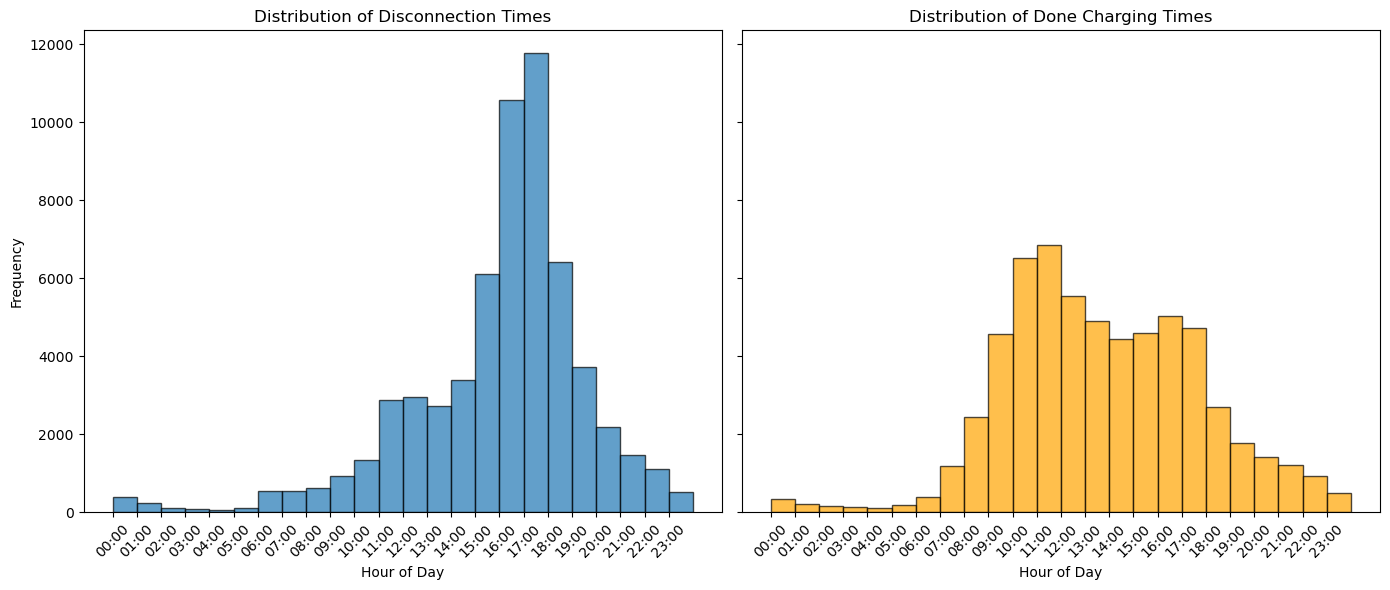

In [34]:
# Extract hours from 'disconnectTime' and 'doneChargingTime' for distribution analysis
disconnect_hours = data_unique['disconnectTime'].dt.hour
done_charging_hours = data_unique['doneChargingTime'].dt.hour

# Create subplots for the histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot histogram for disconnection times
axes[0].hist(disconnect_hours, bins=24, range=(0, 24), edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Disconnection Times')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(0, 24))
axes[0].set_xticklabels([f"{hour:02d}:00" for hour in range(24)], rotation=45)

# Plot histogram for done charging times
axes[1].hist(done_charging_hours, bins=24, range=(0, 24), edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribution of Done Charging Times')
axes[1].set_xlabel('Hour of Day')
axes[1].set_xticks(range(0, 24))
axes[1].set_xticklabels([f"{hour:02d}:00" for hour in range(24)], rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The analysis of daily patterns reveals that most charging sessions occur between 7:00 AM and 5:00 PM. Within the context of the data, this suggests that these times correspond to when most individuals are either at the university or at work. This observation is further supported by the detailed examination of connection times and disconnection times for each hour.

Additionally, it is noteworthy that the charging sessions, measured from the connection time to the disconnection time, are generally longer than the actual charging process required to fully charge a vehicle (measured from the connection time to the done charging time). This indicates that vehicles often remain connected to the charging station well after they are fully charged.

#### Weekly patterns

Bar chart of charging events distributed across the weekdays.

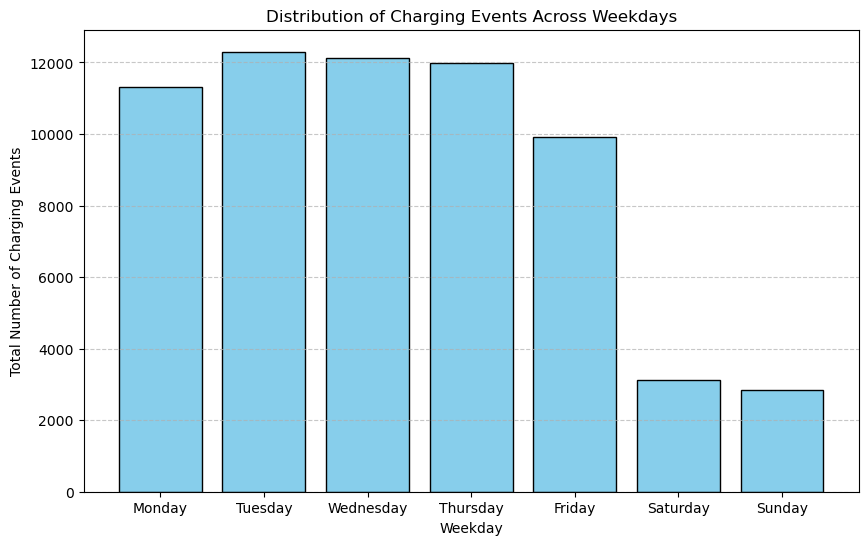

In [35]:
# Extract weekdays (0=Monday, 6=Sunday) from 'connectionTime'
data_unique['weekday'] = data_unique['connectionTime'].dt.dayofweek  # Add a weekday column

# Create a list of weekday names for labeling
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Initialize an array to count active sessions for each weekday
active_sessions_by_weekday = np.zeros(7)

# Calculate active charging sessions for each weekday
for index, row in data_unique.iterrows():
    # Get the range of days spanned by the charging event
    start_date = row['connectionTime'].date()
    end_date = row['disconnectTime'].date()
    
    # If the session spans multiple days
    if start_date != end_date:
        days_spanned = pd.date_range(start=start_date, end=end_date, freq='D')
        for day in days_spanned:
            active_sessions_by_weekday[day.weekday()] += 1
    else:
        # Single-day session
        active_sessions_by_weekday[start_date.weekday()] += 1

# Plot the distribution as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(7), active_sessions_by_weekday, tick_label=weekday_labels, color='skyblue', edgecolor='black')
plt.title('Distribution of Charging Events Across Weekdays')
plt.xlabel('Weekday')
plt.ylabel('Total Number of Charging Events')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Nominal analysis of total charging sessions differentiated between weekdays and weekends.

In [36]:
# Extract weekday (0 = Monday, 6 = Sunday) from 'connectionTime'
data_unique['weekday'] = data_unique['connectionTime'].dt.dayofweek

# Filter sessions for weekdays (0-4) and weekends (5-6)
weekday_sessions = data_unique[data_unique['weekday'] < 5]  # Monday to Friday
weekend_sessions = data_unique[data_unique['weekday'] >= 5]  # Saturday and Sunday

# Count sessions for weekdays and weekends
weekday_count = len(weekday_sessions)
weekend_count = len(weekend_sessions)
total_count = weekday_count + weekend_count

# Calculate the percentage of sessions on the weekend
weekend_percentage = (weekend_count / total_count) * 100

# Print results
print(f"Charging sessions during the week (Monday to Friday): {weekday_count}")
print(f"Charging sessions during the weekend (Saturday and Sunday): {weekend_count}")
print(f"Total charging sessions: {total_count}")
print(f"The percentage of charging sessions on the weekend is {weekend_percentage:.2f}%.")

Charging sessions during the week (Monday to Friday): 55748
Charging sessions during the weekend (Saturday and Sunday): 5202
Total charging sessions: 60950
The percentage of charging sessions on the weekend is 8.53%.


Heatmap for analyzing weekdays categorized by hours and the distribution of connection times.

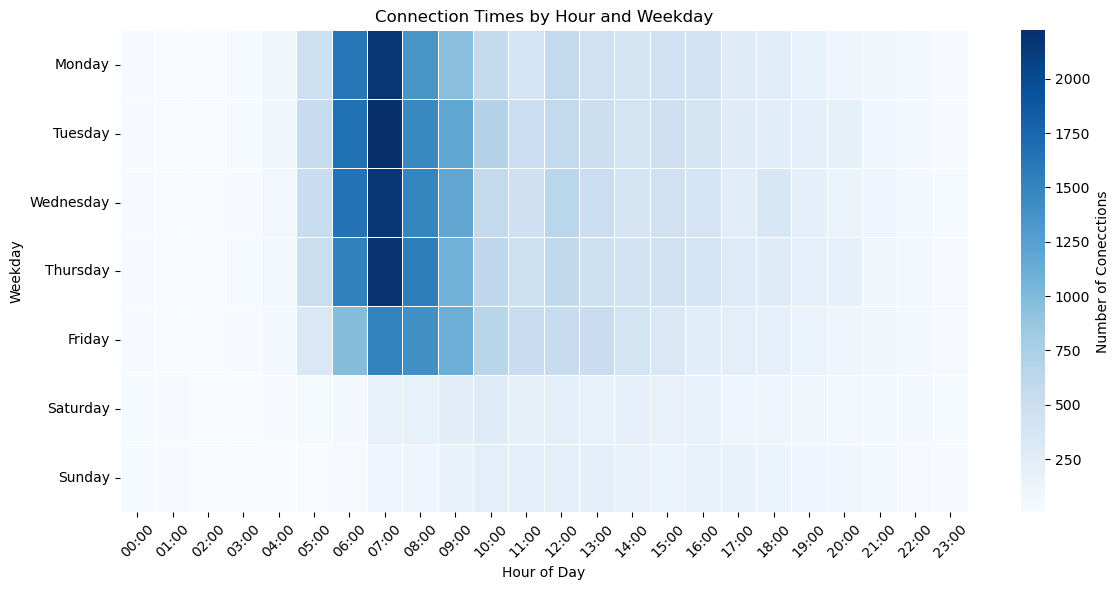

In [37]:
# Extract weekday and hour from connectionTime
data_unique['weekday'] = data_unique['connectionTime'].dt.dayofweek  # 0=Monday, 6=Sunday
data_unique['hour'] = data_unique['connectionTime'].dt.hour

# Create a pivot table to count charging events for each combination of weekday and hour
heatmap_data = data_unique.pivot_table(
    index='weekday', 
    columns='hour', 
    values='connectionTime', 
    aggfunc='count', 
    fill_value=0
)

# Define weekday labels for the heatmap
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=False, fmt="d", linewidths=0.5, cbar_kws={'label': 'Number of Conecctions'})
plt.title('Connection Times by Hour and Weekday')
plt.xlabel('Hour of Day')
plt.ylabel('Weekday')
plt.yticks(ticks=np.arange(7) + 0.5, labels=weekday_labels, rotation=0)
plt.xticks(ticks=np.arange(24) + 0.5, labels=[f"{h:02d}:00" for h in range(24)], rotation=45)
plt.tight_layout()
plt.show()

The analysis of weekly patterns in charging events reveals a clear trend: there are significantly more charging sessions on weekdays compared to weekends (only 8.53% of the total charging sessions are on Weekends). Starting from Friday, the number of sessions gradually declines, with a sharp drop on Saturday and Sunday. In the context of the data, this suggests that most individuals charge their vehicles during weekdays, while they are at work or university. This behavior aligns with the analysis of the daily patterns.


#### Seasonal patterns

Bar chart showing the distribution of charging sessions throughout the year, categorized by seasons.

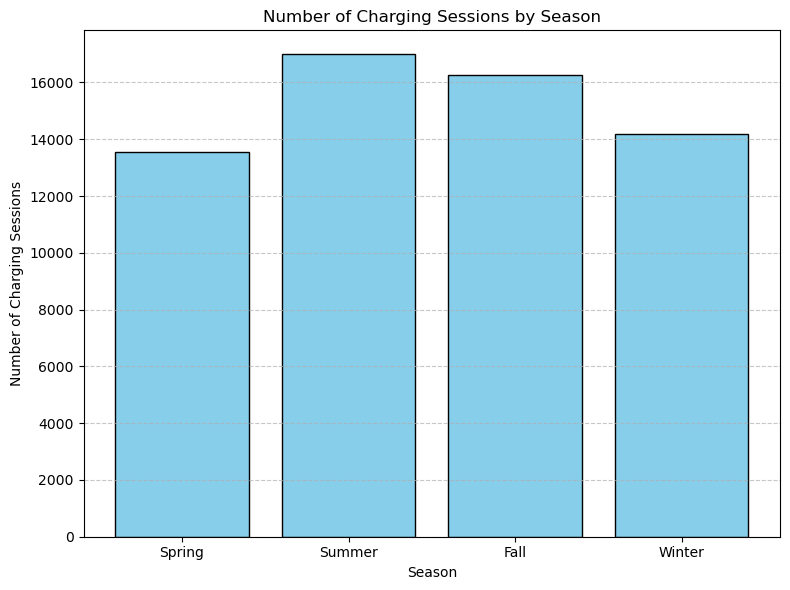

In [38]:
# Define a function to map months to seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Use groupby to count sessions by season
sessions_by_season = (
    data_unique['connectionTime']
    .dt.month
    .map(get_season)  # Map months to seasons
    .value_counts()
    .reindex(['Spring', 'Summer', 'Fall', 'Winter'])  # Sort seasons
)

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(sessions_by_season.index, sessions_by_season.values, color='skyblue', edgecolor='black')
plt.title('Number of Charging Sessions by Season')
plt.xlabel('Season')
plt.ylabel('Number of Charging Sessions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Calculation of correlations between charging events and individual weather factors.

In [39]:
# Extract month for grouping
data_unique['month'] = data_unique['connectionTime'].dt.month
weather_unique['month'] = weather_unique['timestamp'].dt.month

# Aggregate monthly charging sessions
monthly_sessions = data_unique.groupby('month').size().rename('charging_sessions')

# Select only numeric columns for weather and aggregate monthly means
numeric_weather_cols = weather_unique.select_dtypes(include=['float64', 'int64']).columns
monthly_weather = weather_unique.groupby('month')[numeric_weather_cols].mean()

# Merge weather data with charging sessions
monthly_data = pd.merge(monthly_sessions, monthly_weather, left_index=True, right_index=True)

# Calculate correlations
correlations = monthly_data.corr()

# Display the correlations for charging sessions
charging_correlations = correlations['charging_sessions'].sort_values(ascending=False)
print("Correlations with Charging Sessions:\n", charging_correlations)


Correlations with Charging Sessions:
 charging_sessions    1.000000
cloud_cover          0.694439
temperature          0.669904
felt_temperature     0.667264
windspeed           -0.018012
pressure            -0.552198
precipitation       -0.593875
Name: charging_sessions, dtype: float64


Diagrams for analyzing the correlation between weather factors, seasons, and charging sessions, divided into positively correlated and negatively correlated weather factors.

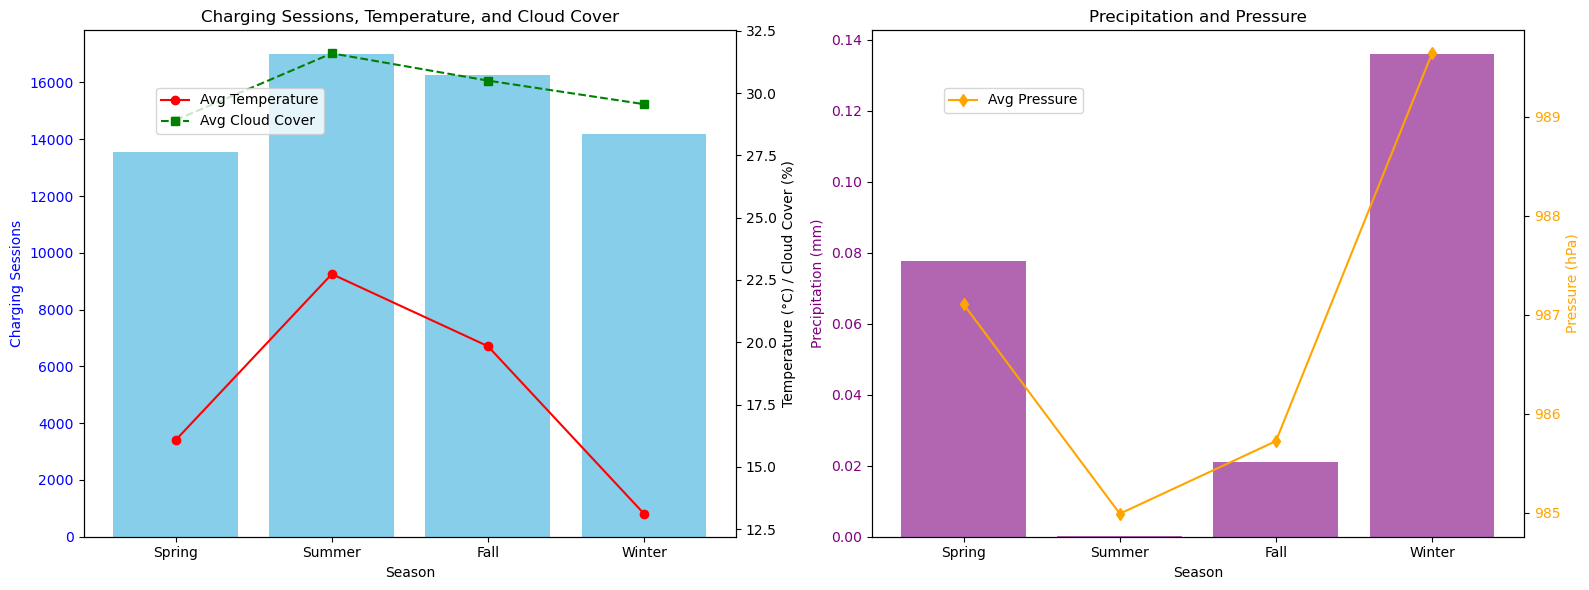

In [40]:
# Assign seasons to weather and charging session data
data_unique['season'] = data_unique['connectionTime'].dt.month.map(get_season)
weather_unique['season'] = weather_unique['timestamp'].dt.month.map(get_season)

# Aggregate Charging Sessions by Season
charging_sessions_by_season = data_unique.groupby('season').size()

# Select only numeric columns for weather data
numeric_weather_cols = weather_unique.select_dtypes(include=['float64', 'int64']).columns

# Aggregate Weather Data by Season (Average for numeric columns only)
weather_by_season = weather_unique.groupby('season')[numeric_weather_cols].mean()

# Combine Charging Sessions and Weather Data
seasonal_data = pd.DataFrame({
    'charging_sessions': charging_sessions_by_season,
    'avg_temperature': weather_by_season['temperature'],
    'avg_cloud_cover': weather_by_season['cloud_cover'],
    'avg_precipitation': weather_by_season['precipitation'],
    'avg_pressure': weather_by_season['pressure']
}).reindex(['Spring', 'Summer', 'Fall', 'Winter'])

# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- First Plot: Charging Sessions, Temperature, and Cloud Cover ---
ax1.bar(seasonal_data.index, seasonal_data['charging_sessions'], color='skyblue', label='Charging Sessions')
ax1.set_ylabel('Charging Sessions', color='blue')
ax1.set_xlabel('Season')
ax1.tick_params(axis='y', labelcolor='blue')

# Add Secondary Axis for Temperature and Cloud Cover
ax1_2 = ax1.twinx()
ax1_2.plot(seasonal_data.index, seasonal_data['avg_temperature'], color='red', marker='o', label='Avg Temperature')
ax1_2.plot(seasonal_data.index, seasonal_data['avg_cloud_cover'], color='green', marker='s', linestyle='--', label='Avg Cloud Cover')
ax1_2.set_ylabel('Temperature (°C) / Cloud Cover (%)', color='black')
ax1_2.tick_params(axis='y', labelcolor='black')

ax1.set_title('Charging Sessions, Temperature, and Cloud Cover')
ax1_2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# --- Second Plot: Precipitation and Pressure ---
ax2.bar(seasonal_data.index, seasonal_data['avg_precipitation'], color='purple', alpha=0.6, label='Avg Precipitation')
ax2.set_ylabel('Precipitation (mm)', color='purple')
ax2.set_xlabel('Season')
ax2.tick_params(axis='y', labelcolor='purple')

# Add Secondary Axis for Pressure
ax2_2 = ax2.twinx()
ax2_2.plot(seasonal_data.index, seasonal_data['avg_pressure'], color='orange', marker='d', label='Avg Pressure')
ax2_2.set_ylabel('Pressure (hPa)', color='orange')
ax2_2.tick_params(axis='y', labelcolor='orange')

ax2.set_title('Precipitation and Pressure')
ax2_2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Heatmaps for analyzing the daily connection and disconnection times categorized by seasons.

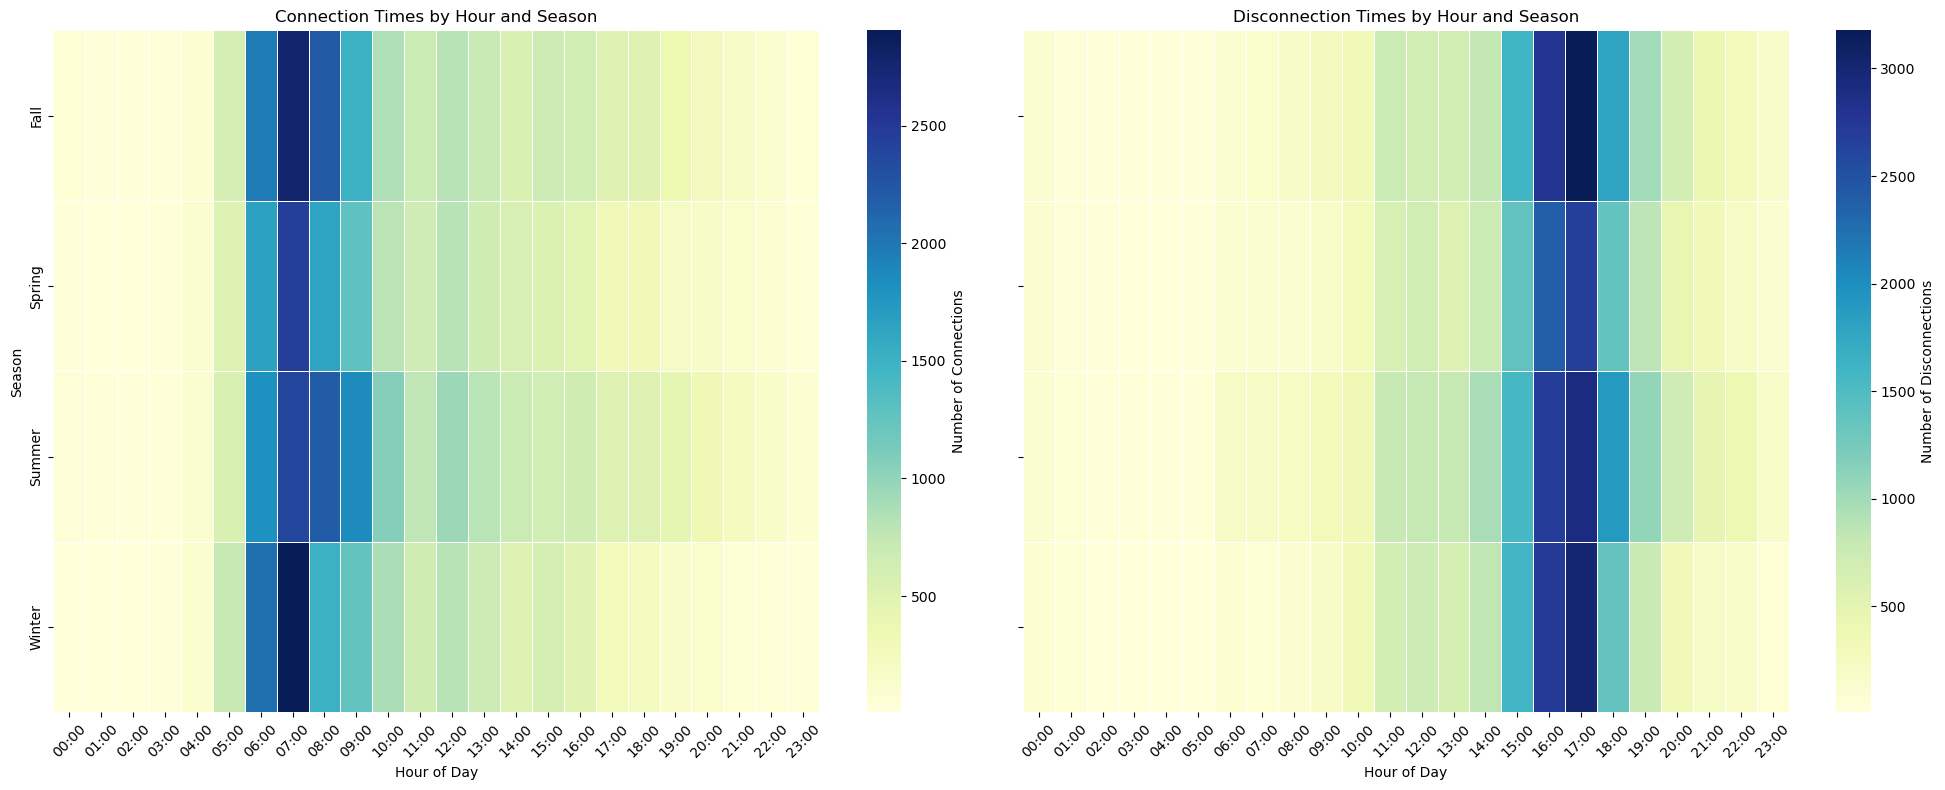

In [41]:
# Map months to seasons
data_unique['season'] = data_unique['connectionTime'].dt.month.map(get_season)
data_unique['connection_hour'] = data_unique['connectionTime'].dt.hour
data_unique['disconnection_hour'] = data_unique['disconnectTime'].dt.hour

# Create pivot tables for the heatmaps
connection_heatmap_data = data_unique.pivot_table(
    index='season', 
    columns='connection_hour', 
    values='connectionTime', 
    aggfunc='count', 
    fill_value=0
)

disconnection_heatmap_data = data_unique.pivot_table(
    index='season', 
    columns='disconnection_hour', 
    values='disconnectTime', 
    aggfunc='count', 
    fill_value=0
)

# Plot the heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Connection Time Heatmap
sns.heatmap(
    connection_heatmap_data, 
    cmap='YlGnBu', 
    annot=False, 
    fmt="d", 
    linewidths=0.5, 
    cbar_kws={'label': 'Number of Connections'}, 
    ax=axes[0]
)
axes[0].set_title('Connection Times by Hour and Season')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Season')
axes[0].set_xticks(np.arange(24) + 0.5)
axes[0].set_xticklabels([f"{h:02d}:00" for h in range(24)], rotation=45)

# Disconnection Time Heatmap
sns.heatmap(
    disconnection_heatmap_data, 
    cmap='YlGnBu', 
    annot=False, 
    fmt="d", 
    linewidths=0.5, 
    cbar_kws={'label': 'Number of Disconnections'}, 
    ax=axes[1]
)
axes[1].set_title('Disconnection Times by Hour and Season')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('')  # Remove duplicate ylabel
axes[1].set_xticks(np.arange(24) + 0.5)
axes[1].set_xticklabels([f"{h:02d}:00" for h in range(24)], rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

The analysis of seasonal patterns reveals that the distribution of charging sessions varies across seasons. Charging sessions are most frequent in summer and fall, while winter and spring see the lowest activity levels. Further analysis indicates that this behavior correlates with weather factors: high temperatures and cloudy skies show a positive correlation with charging sessions, while precipitation and pressure have a negative correlation.

A potential hypothesis to explain this pattern is that people engage in more outdoor activities during summer and fall, leading to increased vehicle usage and a greater need for charging.

Moreover, connection and disconnection times are slightly more spread out during the summer compared to other seasons. This suggests a higher level of activity and flexibility in people’s schedules during the summer months. This seasonal variation in behavior highlights the importance of considering both weather conditions and human activity patterns when analyzing charging infrastructure usage.

### 2b)  Key Performance Indicators (KPIs)

#### 1. Utilization Rate of Charging Stations
###### Definition: The proportion of total available charging station time that is being used over a specific time interval. It is calculated as:

###### Why This KPI:

###### Efficiency: Helps assess how effectively the charging stations are being used.
###### Demand vs. Supply: Reveals whether the number of stations or charging points meets demand.
###### Resource Optimization: Identifies underusage or overburden, suggesting potential operational adjustments.

Step 1: Filter Days in both Site IDs with 0 Charging Sessions. Analyze whether the parking lot was closed or simply not used:

In [42]:
# Filter data for SiteID 1 and SiteID 2
data_kpi1_site_1 = data_with_NA[data_with_NA['siteID'] == 1].copy()
data_kpi1_site_2 = data_with_NA[data_with_NA['siteID'] == 2].copy()

# Convert time columns to date format, if not already converted
data_kpi1_site_1['connectionDate'] = data_kpi1_site_1['connectionTime'].dt.date
data_kpi1_site_1['disconnectDate'] = data_kpi1_site_1['disconnectTime'].dt.date

data_kpi1_site_2['connectionDate'] = data_kpi1_site_2['connectionTime'].dt.date
data_kpi1_site_2['disconnectDate'] = data_kpi1_site_2['disconnectTime'].dt.date

# Determine the minimum and maximum date for SiteID 1
min_date_1 = min(data_kpi1_site_1['connectionDate'].min(), data_kpi1_site_1['disconnectDate'].min())
max_date_1 = max(data_kpi1_site_1['connectionDate'].max(), data_kpi1_site_1['disconnectDate'].max())

# Determine the minimum and maximum date for SiteID 2
min_date_2 = min(data_kpi1_site_2['connectionDate'].min(), data_kpi1_site_2['disconnectDate'].min())
max_date_2 = max(data_kpi1_site_2['connectionDate'].max(), data_kpi1_site_2['disconnectDate'].max())

# Create a complete list of all days in the range for SiteID 1
all_days_1 = pd.date_range(start=min_date_1, end=max_date_1).date

# Create a complete list of all days in the range for SiteID 2
all_days_2 = pd.date_range(start=min_date_2, end=max_date_2).date

# Find all days with at least one charging session for SiteID 1
active_days_1 = pd.concat([data_kpi1_site_1['connectionDate'], data_kpi1_site_1['disconnectDate']]).unique()

# Find all days with at least one charging session for SiteID 2
active_days_2 = pd.concat([data_kpi1_site_2['connectionDate'], data_kpi1_site_2['disconnectDate']]).unique()

# Identify days without any charging sessions for SiteID 1
inactive_days_1 = set(all_days_1) - set(active_days_1)

# Identify days without any charging sessions for SiteID 2
inactive_days_2 = set(all_days_2) - set(active_days_2)

# Function to identify consecutive days without charging sessions
def find_consecutive_days(inactive_days_sorted):
    # Convert the sorted days into a DataFrame
    df = pd.DataFrame({"date": inactive_days_sorted})
    df['diff'] = df['date'].diff().dt.days  # Calculate the difference in days

    consecutive_days = []  # List to store consecutive day sequences
    current_streak = []    # Temporary list to store the current streak of consecutive days

    for i, row in df.iterrows():
        if i > 0 and row['diff'] == 1:  # If the difference between two days is 1
            current_streak.append(row['date'])  # Add the day to the current streak
        else:
            if current_streak:  # If a streak ends
                consecutive_days.append(current_streak)  # Append the current streak to the list
                current_streak = []  # Reset the current streak
            current_streak.append(row['date'])  # Start a new streak

    # Add the last streak if it exists
    if current_streak:
        consecutive_days.append(current_streak)

    return consecutive_days

# Sort the days
inactive_days_sorted_1 = sorted(inactive_days_1)
inactive_days_sorted_2 = sorted(inactive_days_2)

# Find longer streaks for both sites
long_streaks_1 = find_consecutive_days(inactive_days_sorted_1)
long_streaks_2 = find_consecutive_days(inactive_days_sorted_2)

# Print long periods without parking guests
print("Longer Periods of consecutive days without charging sessions (Site 1):")
for streak in long_streaks_1:
    if len(streak) > 2:  # Only print if streak is longer than 2 days
        print(f"{streak[0]} to {streak[-1]} ({len(streak)} days)")

print("\nLonger Periods of consecutive days without charging sessions (Site 2):")
for streak in long_streaks_2:
    if len(streak) > 2:  # Only print if streak is longer than 2 days
        print(f"{streak[0]} to {streak[-1]} ({len(streak)} days)")

# Streaks of more than 7 days without a parking guest are considered as closed 
streaks_longer_than_7_1 = [streak for streak in long_streaks_1 if len(streak) > 7]
streaks_longer_than_7_2 = [streak for streak in long_streaks_2 if len(streak) > 7]

# Sum the length of the streaks longer than 7 days. These are the number of days where the sites were closed
sum_long_streaks_1 = sum(len(streak) for streak in streaks_longer_than_7_1)
sum_long_streaks_2 = sum(len(streak) for streak in streaks_longer_than_7_2)

# Print the long streaks length (just for reference)
print(f"\nTotal number of days in streaks > 7 days (Site 1): {sum_long_streaks_1}")
print(f"Total number of days in streaks > 7 days (Site 2): {sum_long_streaks_2}")

# Remove the days from the inactive days that are part of streaks longer than 7 days as here site isconsidered  as closed
def remove_long_streaks(inactive_days, long_streaks, threshold=7):
    # Create a set of days to remove
    days_to_remove = set()
    for streak in long_streaks:
        if len(streak) > threshold:
            days_to_remove.update(streak)

    # Remove the days from the list
    updated_inactive_days = [day for day in inactive_days if day not in days_to_remove]
    return updated_inactive_days

# Remove the long streaks from the inactive days
inactive_days_siteid_1 = remove_long_streaks(inactive_days_1, long_streaks_1)
inactive_days_siteid_2 = remove_long_streaks(inactive_days_2, long_streaks_2)

# Output the updated inactive days
print("\nNumber of considered incative days for Site 1 after removing streaks >7:")
print(len(inactive_days_siteid_1))
print("\nNumber of considered incative days for Site 2 after removing long streaks >7:")
print(len(inactive_days_siteid_2))


Longer Periods of consecutive days without charging sessions (Site 1):
2020-05-23 to 2020-05-25 (3 days)
2020-08-04 to 2020-11-17 (106 days)
2021-07-23 to 2021-07-27 (5 days)

Longer Periods of consecutive days without charging sessions (Site 2):
2020-04-15 to 2020-04-17 (3 days)
2020-04-30 to 2020-05-03 (4 days)
2020-05-05 to 2020-05-08 (4 days)
2020-05-21 to 2020-05-25 (5 days)
2020-08-04 to 2020-11-17 (106 days)

Total number of days in streaks > 7 days (Site 1): 106
Total number of days in streaks > 7 days (Site 2): 106

Number of considered incative days for Site 1 after removing streaks >7:
44

Number of considered incative days for Site 2 after removing long streaks >7:
46


We assume that if there are more than 7 consecutive days without any guests, the site was closed during that period. For example, between 2020-08-04 and 2020-11-17, both sites experienced no parking activity, which we interpret as the site being closed for 106 days. If we have less than or equal to 7 consecutive days without guests, we assume that the parking lot was open but not used.

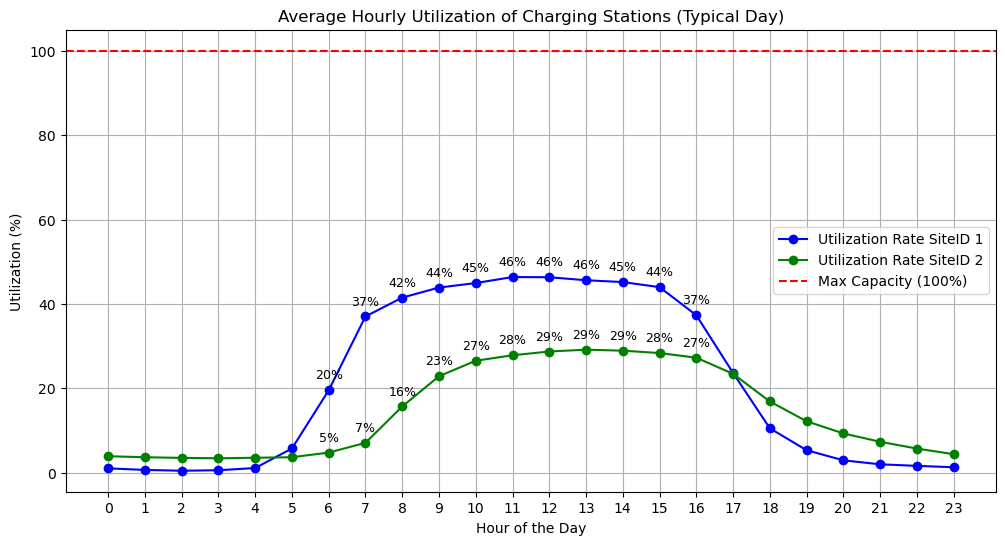

In [43]:
# Function to calculate hourly utilization for a given siteID
def calculate_utilization(site_id, data_with_NA):
    # Filter data for the specified siteID
    data_kpi = data_with_NA[data_with_NA['siteID'] == site_id].copy()

    # Parameters
    num_stations = data_kpi['stationID'].nunique()  # Number of unique charging stations

    # Extract the date and round to the nearest full hour
    data_kpi['connectionDate'] = data_kpi['connectionTime'].dt.date
    data_kpi['connectionHour'] = data_kpi['connectionTime'].dt.hour

    # Create a list of hourly activity data
    hourly_data = []

    # Iterate through each row in the dataset
    for _, row in data_kpi.iterrows():
        start_hour = row['connectionTime'].floor('H')  # Round connection time to the full hour
        end_hour = row['disconnectTime'].floor('H')  # Round disconnection time to the full hour
        current_hour = start_hour
        
        # Loop through each hour the vehicle is charging
        while current_hour <= end_hour:
            # If the hour is 0 (crosses midnight)
            if current_hour.hour == 0 and current_hour.date() != row['connectionTime'].date():
                connection_date = current_hour.date()  # Set the date to the next day
            else:
                connection_date = current_hour.date()  # Otherwise, keep the same date
            
            # Append hourly data
            hourly_data.append({
                'connectionDate': connection_date,  # Ensure the date changes after midnight
                'hour': current_hour.hour, 
                'active_charging': 1  # Mark that the charging station was active during this hour
            })
            
            # Move to the next hour
            current_hour += pd.Timedelta(hours=1)

    # Create DataFrame for the hourly usage data
    hourly_df = pd.DataFrame(hourly_data)

    # Add inactive days with 0 activity for each hour of the day (same code as before)
    inactive_hourly_data = []
    for inactive_day in inactive_days_siteid_1:  # You can modify this for site 2 if needed
        for hour in range(24):
            inactive_hourly_data.append({
                'connectionDate': inactive_day,
                'hour': hour,
                'active_charging': 0
            })

    # Combine the active and inactive hourly data
    hourly_df = pd.concat([hourly_df, pd.DataFrame(inactive_hourly_data)], ignore_index=True)

    # Group by date and hour and count the active charging sessions
    hourly_usage = hourly_df.groupby(['connectionDate', 'hour'])['active_charging'].sum().reset_index()

    # Calculate the total hourly usage per day
    avg_hourly_usage = hourly_usage.groupby('hour')['active_charging'].sum().reset_index()

    # Calculate the utilization rate, using the unique connection dates in hourly_usage for the denominator
    avg_hourly_usage['utilization_rate'] = (avg_hourly_usage['active_charging'] / (hourly_usage['connectionDate'].nunique()) / num_stations) * 100

    return avg_hourly_usage

# Calculate utilization for siteID 1
avg_hourly_usage_1 = calculate_utilization(1, data_with_NA)

# Calculate utilization for siteID 2
avg_hourly_usage_2 = calculate_utilization(2, data_with_NA)

# Visualization
plt.figure(figsize=(12, 6))

# Plot utilization for siteID 1
plt.plot(avg_hourly_usage_1['hour'], avg_hourly_usage_1['utilization_rate'], marker='o', label='Utilization Rate SiteID 1', color='blue')

# Plot utilization for siteID 2
plt.plot(avg_hourly_usage_2['hour'], avg_hourly_usage_2['utilization_rate'], marker='o', label='Utilization Rate SiteID 2', color='green')

# Add horizontal line for max capacity (100%)
plt.axhline(y=100, color='red', linestyle='--', label='Max Capacity (100%)')

# Title and labels
plt.title('Average Hourly Utilization of Charging Stations (Typical Day)')
plt.xlabel('Hour of the Day')
plt.ylabel('Utilization (%)')

# Set X-axis to display each hour from 0 to 23
plt.xticks(range(24))

# Add percentage values above each point on the graph, but only for hours 7 to 16
for i, row in avg_hourly_usage_1.iterrows():
    if 6 <= row['hour'] <= 16:  # Check if the hour is between 7 and 16 (inclusive)
        plt.text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

for i, row in avg_hourly_usage_2.iterrows():
    if 6 <= row['hour'] <= 16:  # Check if the hour is between 7 and 16 (inclusive)
        plt.text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

# Grid and legend
plt.grid()
plt.legend()

# Show the plot
plt.show()

The utilization of both Sites has an average utilization of under 50%, which almost entirely rules out the possibility of overloading. SiteID 1 has a higher Utilization Rate than SiteID 2.

#### 2. Inactive Utilization Rate of Charging Stations
###### Definition: The inactive utilization rate represents the percentage of time a vehicle is still connected to the charging station but is no longer actively charging. It measures the time a station is occupied without contributing to the charging process, indicating inefficiencies or idle time.

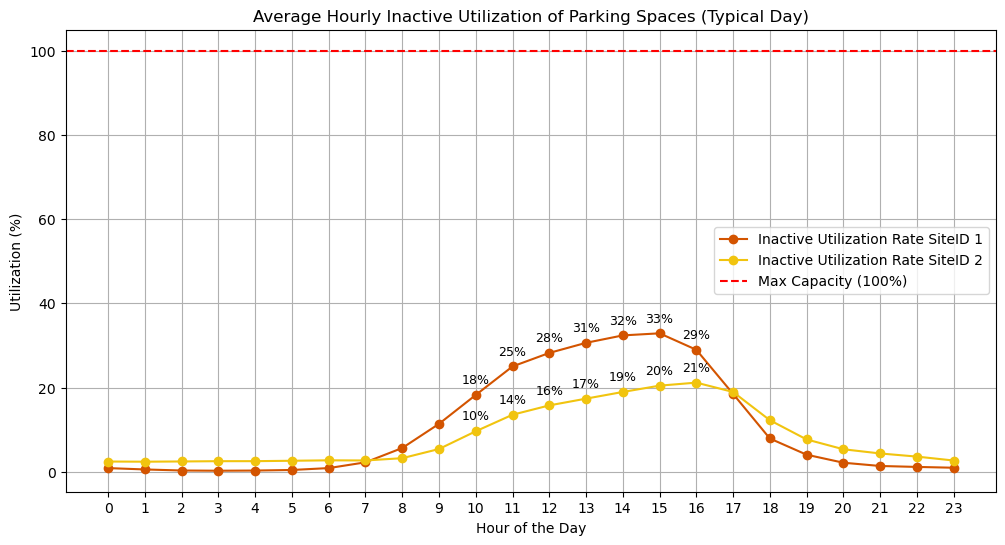

In [44]:
# Function to calculate hourly inactive utilization for a given siteID
def calculate_inactive_utilization(site_id, data_with_NA):
    # Filter data for the specified siteID
    data_kpi = data_with_NA[data_with_NA['siteID'] == site_id].copy()

    # Parameters
    num_spaces = data_kpi['stationID'].nunique()  # Number of unique parking spaces

    # Extract the date and round to the nearest full hour
    data_kpi['doneParkingDate'] = data_kpi['doneChargingTime'].dt.date
    data_kpi['doneParkingHour'] = data_kpi['doneChargingTime'].dt.hour

    # Create a list of hourly activity data for inactive (unoccupied) parking
    hourly_data = []

    # Iterate through each row in the dataset
    for _, row in data_kpi.iterrows():
        # Check if doneParkingTime is not NaT and disconnectTime > doneParkingTime
        if pd.notna(row['doneChargingTime']) and row['disconnectTime'] > row['doneChargingTime']:
            start_hour = row['doneChargingTime'].floor('H')  # Round doneParking time to the full hour
            end_hour = row['disconnectTime'].floor('H')  # Round disconnection time to the full hour
            current_hour = start_hour

            # Loop through each hour the parking space is unoccupied (inactive)
            while current_hour <= end_hour:
                # If the hour is 0 (crosses midnight)
                if current_hour.hour == 0 and current_hour.date() != row['doneChargingTime'].date():
                    parking_date = current_hour.date()  # Set the date to the next day
                else:
                    parking_date = current_hour.date()  # Otherwise, keep the same date

                # Append hourly data for inactive usage
                hourly_data.append({
                    'doneParkingDate': parking_date,  # Ensure the date changes after midnight
                    'hour': current_hour.hour, 
                    'inactive_utilization': 1  # Mark that the parking space was unoccupied (inactive) during this hour
                })
            
                # Move to the next hour
                current_hour += pd.Timedelta(hours=1)

    # Create DataFrame for the hourly inactive usage data
    hourly_df = pd.DataFrame(hourly_data)

    # Group by date and hour and count the inactive parking sessions
    hourly_usage = hourly_df.groupby(['doneParkingDate', 'hour'])['inactive_utilization'].sum().reset_index()

    # Calculate the total hourly usage per day (inactive utilization)
    avg_hourly_usage = hourly_usage.groupby('hour')['inactive_utilization'].sum().reset_index()

    # Calculate the utilization rate, using the unique parking dates for the denominator
    avg_hourly_usage['utilization_rate'] = (avg_hourly_usage['inactive_utilization'] / (hourly_usage['doneParkingDate'].nunique()) / num_spaces) * 100

    return avg_hourly_usage

# Calculate inactive utilization for siteID 1
avg_hourly_usage_1_inactive = calculate_inactive_utilization(1, data_with_NA)

# Calculate inactive utilization for siteID 2
avg_hourly_usage_2_inactive = calculate_inactive_utilization(2, data_with_NA)

# Visualization
plt.figure(figsize=(12, 6))

# Plot inactive utilization for siteID 1
plt.plot(avg_hourly_usage_1_inactive['hour'], avg_hourly_usage_1_inactive['utilization_rate'], marker='o', label='Inactive Utilization Rate SiteID 1', color='#D35400')

# Plot inactive utilization for siteID 2
plt.plot(avg_hourly_usage_2_inactive['hour'], avg_hourly_usage_2_inactive['utilization_rate'], marker='o', label='Inactive Utilization Rate SiteID 2', color='#F1C40F')

# Add horizontal line for max capacity (100%)
plt.axhline(y=100, color='red', linestyle='--', label='Max Capacity (100%)')

# Title and labels
plt.title('Average Hourly Inactive Utilization of Parking Spaces (Typical Day)')
plt.xlabel('Hour of the Day')
plt.ylabel('Utilization (%)')

# Set X-axis to display each hour from 0 to 23
plt.xticks(range(24))

# Add percentage values above each point on the graph, but only for hours 7 to 16
for i, row in avg_hourly_usage_1_inactive.iterrows():
    if 10 <= row['hour'] <= 16:  # Check if the hour is between 7 and 16 (inclusive)
        plt.text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

for i, row in avg_hourly_usage_2_inactive.iterrows():
    if 10 <= row['hour'] <= 16:  # Check if the hour is between 7 and 16 (inclusive)
        plt.text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

# Grid and legend
plt.grid()
plt.legend()

# Show the plot
plt.show()

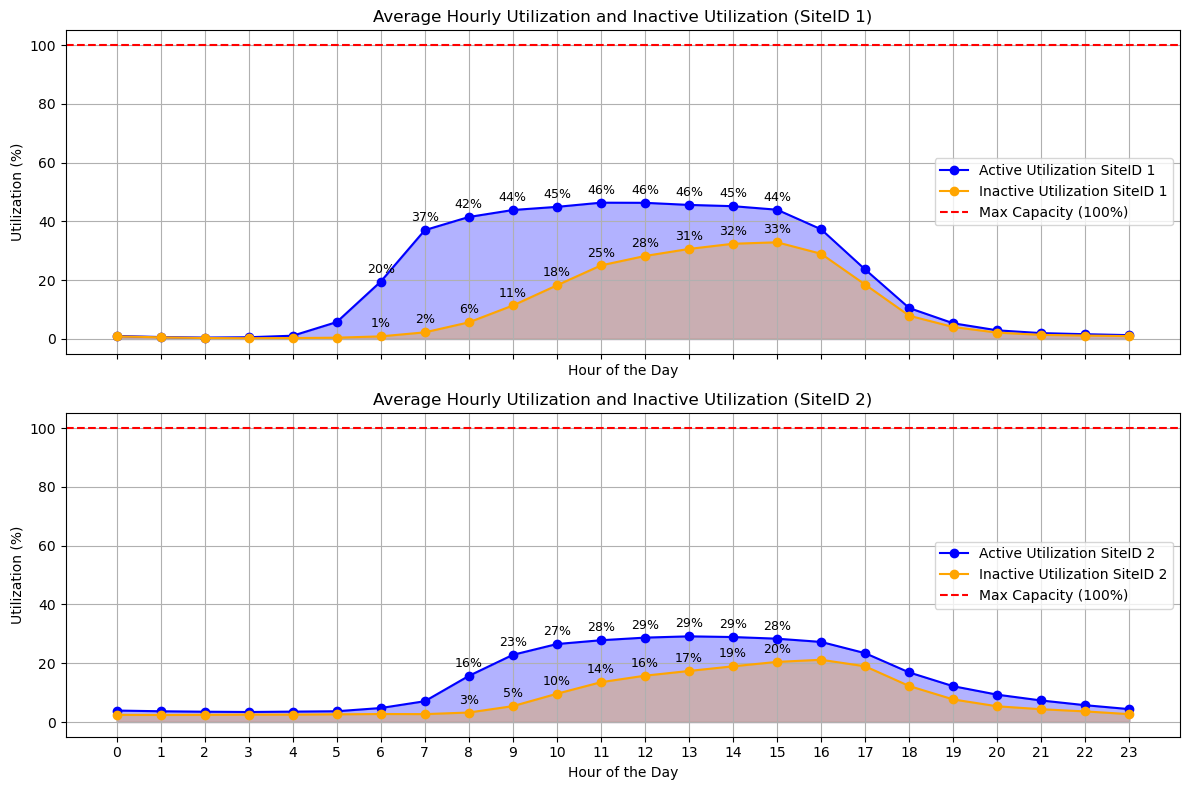

In [45]:
# Create subplots: One for SiteID 1 and one for SiteID 2
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot for SiteID 1
axs[0].plot(avg_hourly_usage_1['hour'], avg_hourly_usage_1['utilization_rate'], marker='o', label='Active Utilization SiteID 1', color='blue')
axs[0].plot(avg_hourly_usage_1_inactive['hour'], avg_hourly_usage_1_inactive['utilization_rate'], marker='o', label='Inactive Utilization SiteID 1', color='orange')

# Fill the area under the active utilization curve for SiteID 1
axs[0].fill_between(avg_hourly_usage_1['hour'], 0, avg_hourly_usage_1['utilization_rate'], color='blue', alpha=0.3)
# Fill the area under the inactive utilization curve for SiteID 1
axs[0].fill_between(avg_hourly_usage_1_inactive['hour'], 0, avg_hourly_usage_1_inactive['utilization_rate'], color='orange', alpha=0.3)

# Title and labels for SiteID 1
axs[0].set_title('Average Hourly Utilization and Inactive Utilization (SiteID 1)')
axs[0].set_ylabel('Utilization (%)')  # Ensure ylabel is on the upper plot
axs[0].set_xlabel('Hour of the Day')
axs[0].axhline(y=100, color='red', linestyle='--', label='Max Capacity (100%)')  # Max capacity line

# Add percentage values above each point on the graph, but only for hours 10 to 16
for i, row in avg_hourly_usage_1.iterrows():
    if 6 <= row['hour'] <= 15:
        axs[0].text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

for i, row in avg_hourly_usage_1_inactive.iterrows():
    if 6 <= row['hour'] <= 15:
        axs[0].text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

# Plot for SiteID 2
axs[1].plot(avg_hourly_usage_2['hour'], avg_hourly_usage_2['utilization_rate'], marker='o', label='Active Utilization SiteID 2', color='blue')
axs[1].plot(avg_hourly_usage_2_inactive['hour'], avg_hourly_usage_2_inactive['utilization_rate'], marker='o', label='Inactive Utilization SiteID 2', color='orange')

# Fill the area under the active utilization curve for SiteID 2
axs[1].fill_between(avg_hourly_usage_2['hour'], 0, avg_hourly_usage_2['utilization_rate'], color='blue', alpha=0.3)
# Fill the area under the inactive utilization curve for SiteID 2
axs[1].fill_between(avg_hourly_usage_2_inactive['hour'], 0, avg_hourly_usage_2_inactive['utilization_rate'], color='orange', alpha=0.3)

# Title and labels for SiteID 2
axs[1].set_title('Average Hourly Utilization and Inactive Utilization (SiteID 2)')
axs[1].set_xlabel('Hour of the Day')
axs[1].set_ylabel('Utilization (%)')  # Make sure the ylabel is also on the second plot
axs[1].axhline(y=100, color='red', linestyle='--', label='Max Capacity (100%)')  # Max capacity line

# Add percentage values above each point on the graph, but only for hours 8 to 16
for i, row in avg_hourly_usage_2.iterrows():
    if 8 <= row['hour'] <= 15:
        axs[1].text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

for i, row in avg_hourly_usage_2_inactive.iterrows():
    if 8 <= row['hour'] <= 15:
        axs[1].text(row['hour'], row['utilization_rate'] + 2, f'{row["utilization_rate"]:.0f}%', ha='center', va='bottom', fontsize=9)

# Set X-axis to display each hour from 0 to 23
axs[1].set_xticks(range(24))

# Grid and legend for both subplots
axs[0].grid(True)
axs[1].grid(True)

axs[0].legend(loc='center right')
axs[1].legend(loc='center right')

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

An interesting observation is the noticeably high proportion of vehicles that remain connected to the charging stations without further charging. This idle time suggests a significant number of vehicles occupy charging spots even after the charging process has been completed, highlighting an opportunity to improve the overall efficiency of the charging infrastructure.

However, at present, this idle time after charging does not pose a significant problem, as the overall utilization remains low. The available charging capacity is not being fully utilized, so there is no immediate concern regarding limited access for other vehicles in need of charging. Nonetheless, addressing this inefficiency could enhance the capacity and accessibility of the stations in the future.

#### c)  Identifying the Public Charging Hub

In this section, we aim to determine which of the two sites is the public charging hub. By analyzing the provided data and combining insights from previous descriptive analytics with domain knowledge of how private company parking (reserved for employees) and public university charging stations typically operate, we will evaluate key characteristics to distinguish between the two sites.

We have a look at different criteria to make our decision:

- Time distribution
- User diversity
- Session duration

First we take a closer look at the stations. We want to know exactly how many charging stations are in the garages.

In [46]:
def count_stations_per_site(df):
    """
    Count the number of unique stations per site.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing 'stationID' and 'siteID' columns.

    Returns:
        pd.Series: Number of unique stations per site.
    """
    if 'stationID' not in df.columns or 'siteID' not in df.columns:
        raise ValueError("The provided DataFrame must contain 'stationID' and 'siteID' columns.")
    
    return df.groupby('siteID')['stationID'].nunique()

# Count unique stations for each site
station_counts = count_stations_per_site(data_unique)
print("Number of unique stations per site:")
print(station_counts)

Number of unique stations per site:
siteID
1    52
2    54
Name: stationID, dtype: int64


There are 52 charging stations in the first garage (site_id=1) and 54 stations in the second garage (site_id=2).

#### **Time distribution**
To better understand how the charging stations are used, we analyze their temporal distribution. This involves examining patterns across days of the week and hours of the day to identify trends and peak usage periods.

We extract the hour of the day and the weekday from the _connectionTime column_ in the dataset. This allows us to examine how usage varies throughout the day and the week. The hour is extracted using `.dt.hour`, while the weekday is derived using `.dt.day_name()`. These new columns enable us to visualize the usage patterns based on time of day and weekday, providing further insights into the site type.

In [47]:
data_1['hour'] = data_1['connectionTime'].dt.hour
data_1['weekday'] = data_1['connectionTime'].dt.day_name()

data_2['hour'] = data_2['connectionTime'].dt.hour
data_2['weekday'] = data_2['connectionTime'].dt.day_name()

**1. Day Of the Week Analysis (weekly distribution):**
This bar chart shows the number of charging events for each day of the week. This will help us understand if there are variations in usage between weekdays and weekends. At the university (public site), we expect higher usage during weekdays, aligning with academic schedules, and possibly lower usage on weekends. At the firm (private site), consistent weekday usage is expected, reflecting employee commutes, with little to no activity on weekends.

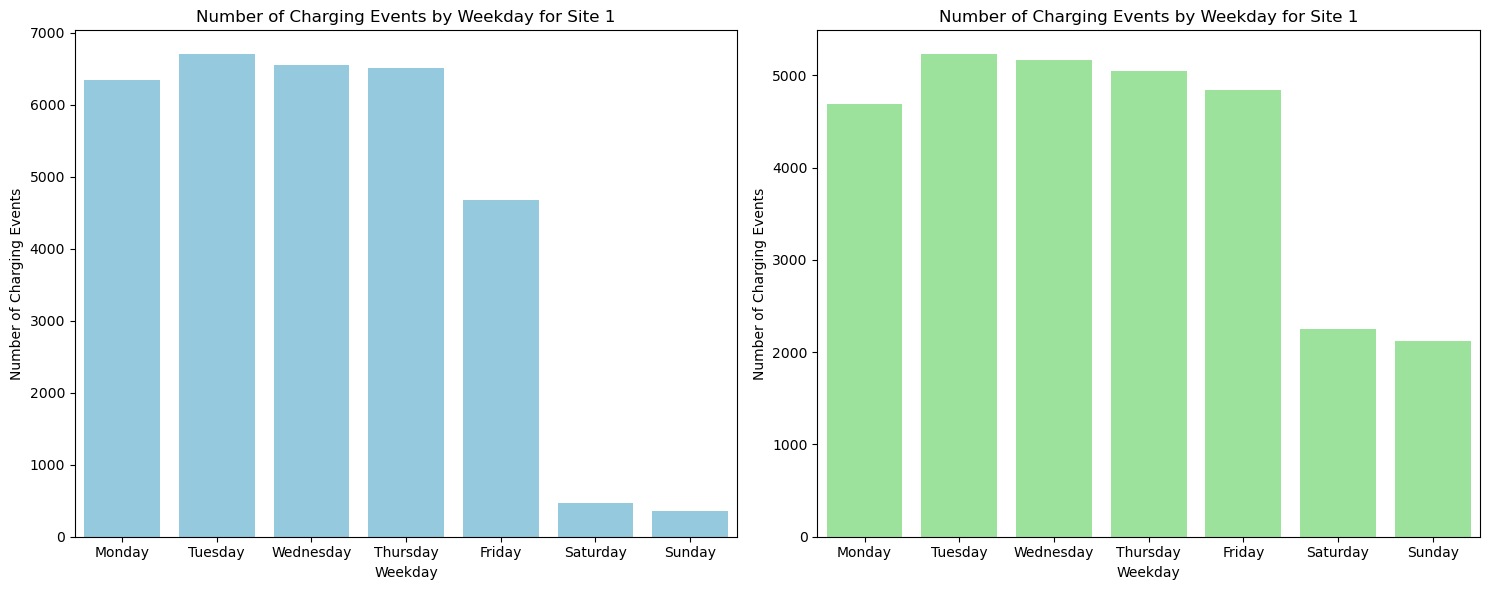

In [48]:
# Bar chart of charging events per weekday

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=data_1, x='weekday', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], color="skyblue", ax=axes[0])
axes[0].set_title('Number of Charging Events by Weekday for Site 1')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Number of Charging Events')

sns.countplot(data=data_2, x='weekday', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], color="lightgreen", ax=axes[1])
axes[1].set_title('Number of Charging Events by Weekday for Site 1')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Number of Charging Events')

plt.tight_layout()
plt.show()

Both sites exhibit a general trend of higher usage on weekdays compared to weekends. However, there is a noticeable difference between the two sites. Site 2 shows more usage on weekends compared to Site 1, which aligns with the typical usage pattern for public charging stations. Public sites, like the one near the university, often experience higher demand on weekends, not only from students attending events or studying but also from other visitors who may need to use the public parking garage. In contrast, private sites, such as the company parking garage in Site 1, see much lower usage on weekends, as they are mainly used by employees during the working week. Less than a tenth of the charging sessions take place at weekends. At station 2, the figure is slightly higher. There, the utilization at weekends is about half as high as on a working day.

**2. Time of the Day Analysis (hourly distribution):**
This histogram visualizes the number of charging events for each hour of the day. The x-axis represents the hours (0 to 23), and the y-axis shows the total number of charging events that occurred during each hour. This visualization helps us identify peak usage times throughout the day, which can provide insights into typical charging patterns.

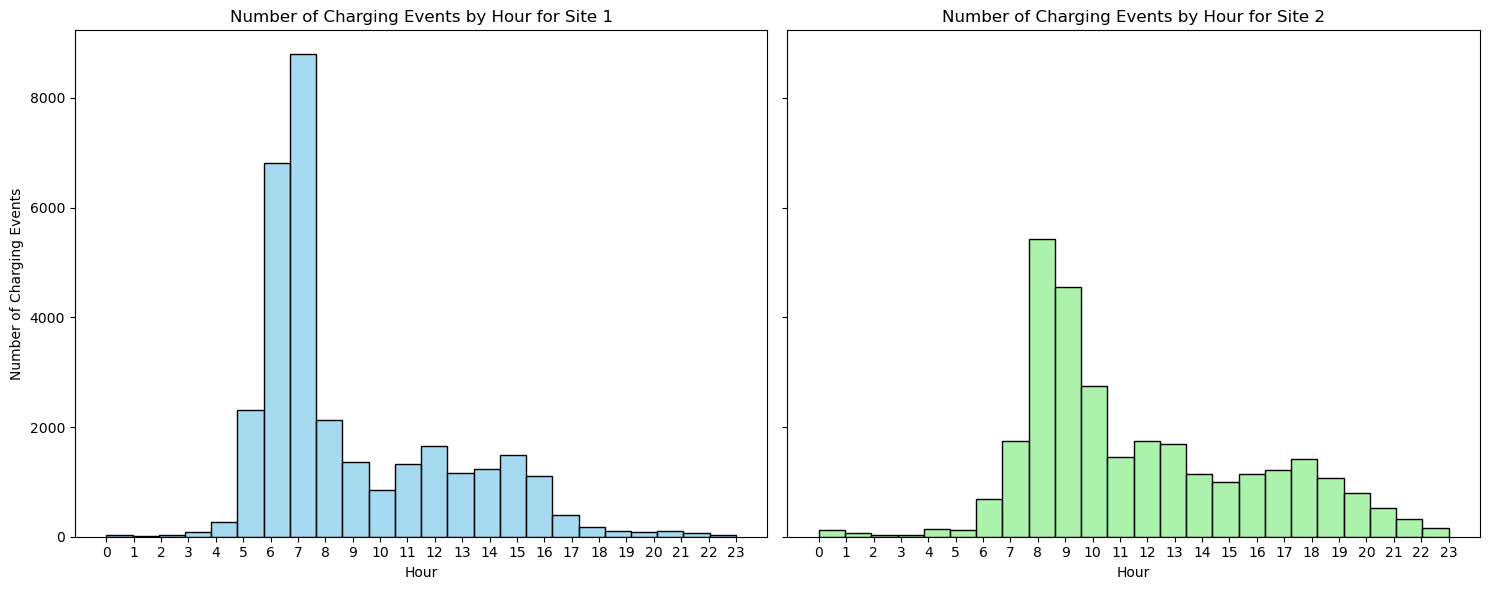

In [49]:
fig, axes = plt.subplots(1,2, figsize=(15,6), sharey=True)

sns.histplot(data=data_1, x='hour', bins=24, color="skyblue", ax=axes[0])

# Histogram of charging events per hour with full hours on the X-axis
#site 1
axes[0].set_title('Number of Charging Events by Hour for Site 1')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Number of Charging Events')
axes[0].set_xticks(ticks=range(0, 24), labels=[f"{hour}" for hour in range(24)])  


sns.histplot(data=data_2, x='hour', bins=24, color="lightgreen", ax=axes[1])

axes[1].set_title('Number of Charging Events by Hour for Site 2')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Number of Charging Events')
axes[1].set_xticks(ticks=range(0, 24), labels=[f"{hour}" for hour in range(24)])  

plt.tight_layout()
plt.show()

If you look at the utilization for the specific times of the day, you can see patterns. For Site 1, there are clear peaks at **6:00 and 7:00 AM**, while the peaks for Site 2 are not so extreme and are at **8:00 and 9:00 AM**. respectively. 

For Site 1, the charging events primarily occur from around **5:00 AM to 5:00 PM**, with a significant decline in usage afterward. This pattern suggests that the site is most heavily used during business hours, which is often characteristic of sites serving a more specific user group, such as employees of a company.

In contrast, for Site 2, the charging events occur throughout a longer period, from approximately **6:00 AM to 11:00 PM**. This extended period of usage may indicate that the site is open to a broader range of users, with charging events spanning both daytime and evening hours, which is a typical feature of public charging hubs.

&#8594;
These insights strongly suggest that Site 2 is the public charging station, likely located at the university, while Site 1 is the private company parking garage, as the usage pattern matches the expected behavior for these types of locations.

#### **User Count and Diversity**

In this step, we aim to determine whether the site is primarily used by repeat users or a diverse range of users. A public site is expected to have a higher number of unique users, as it serves a broader, more varied group. In contrast, a private site, like a company parking garage, might show repeated usage by the same set of users, as it is typically restricted to employees or specific individuals.

First, we count the unique user IDs (`userID`) for each site and determine the number of missing values in the userID column.

In [50]:
# Count the unique userIDs for siteID 1
unique_users_per_site_1 = data_1['userID'].nunique()

# Display the result for verification
print(f"Number of unique (distinct) userIDs for Site 1: {unique_users_per_site_1}")

# Count the missing values in the 'userID' column
missing_values_userID_1 = data_1['userID'].isnull().sum()

# Output the number of missing values
print(f"Number of missing values in 'userID' for Site 1: {missing_values_userID_1}")


Number of unique (distinct) userIDs for Site 1: 511
Number of missing values in 'userID' for Site 1: 1433


In [51]:
# Count the unique userIDs for siteID 2
unique_users_per_site_2 = data_2['userID'].nunique()

# Display the result for verification
print(f"Number of unique (distinct) userIDs for SIte 2: {unique_users_per_site_2}")

# Count the missing values in the 'userID' column
missing_values_userID_2 = data_2['userID'].isnull().sum()

# Output the number of missing values
print(f"Number of missing values in 'userID' for Site 2: {missing_values_userID_2}")

Number of unique (distinct) userIDs for SIte 2: 459
Number of missing values in 'userID' for Site 2: 14873


Now we create a comparison DataFrame to visualize the number of unique users for Site 1 and Site 2, and generate a bar chart to display the comparison between the two sites.

In [52]:
#compare number of unique user IDs per side
comparison_unique_users = pd.DataFrame({
    'siteID': ['site1', 'site2'],
    'unique_users': [unique_users_per_site_1, unique_users_per_site_2]
})

In [53]:
#compare number of missing user IDs per site
comparison_missing_users = pd.DataFrame({
    'siteID': ['site1', 'site2'],
    'unique_users': [missing_values_userID_1, missing_values_userID_2]
})

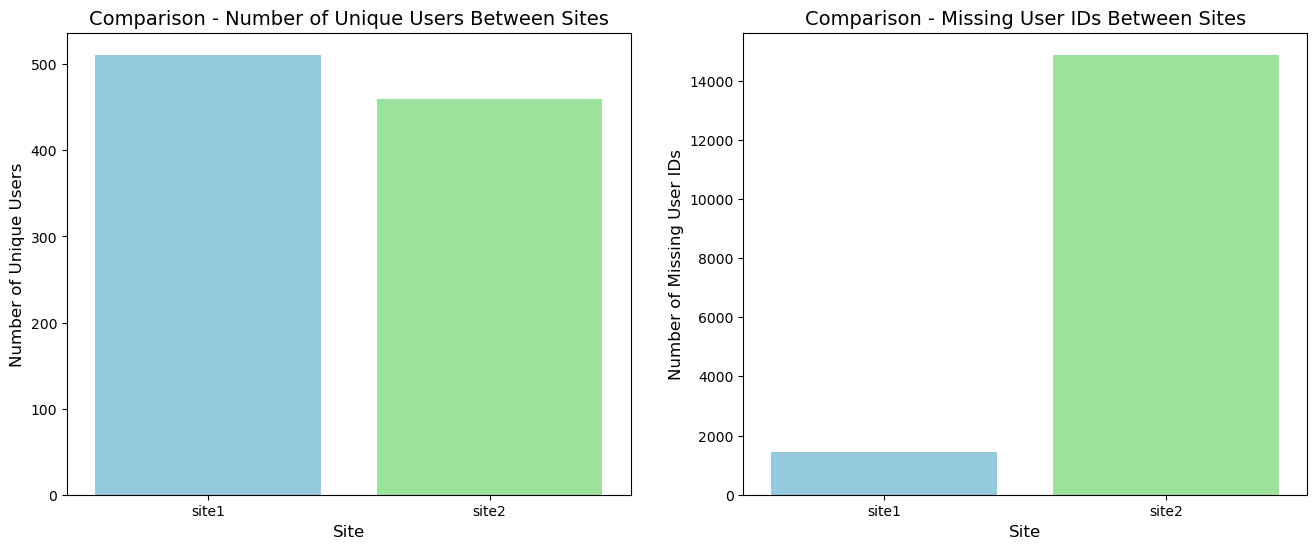

In [54]:
custom_palette = {'site1': 'skyblue', 'site2': 'lightgreen'}


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the number of unique users per site
sns.barplot(x='siteID', y='unique_users', data=comparison_unique_users, palette=custom_palette, ax=axes[0])
axes[0].set_title('Comparison - Number of Unique Users Between Sites', fontsize=14)
axes[0].set_xlabel('Site', fontsize=12)
axes[0].set_ylabel('Number of Unique Users', fontsize=12)

# Plot for the number of missing user IDs per site
sns.barplot(x='siteID', y='unique_users', data=comparison_missing_users, palette=custom_palette, ax=axes[1])
axes[1].set_title('Comparison - Missing User IDs Between Sites', fontsize=14)
axes[1].set_xlabel('Site', fontsize=12)
axes[1].set_ylabel('Number of Missing User IDs', fontsize=12)



# Display the plots
plt.show()

The diagrams reveal several insights about the two sites, Site 1 and Site 2.
- Unique Users: Both sites show a similar number of unique users, with values in the same range for both locations. This indicates that, in terms of unique user activity, both sites are relatively comparable.
- Missing User IDs: However, the second diagram reveals a significant difference in the number of missing userID values. Site 2 has 14,873 missing values compared to only 1,433 for Site 1. 

Conclusion: The high number of missing user IDs at Site 2 suggests it is the public charging hub, likely at the university, where there is a mix of registered and non-registered users. In contrast, Site 1, with fewer missing IDs, is more consistent with a private site, such as a company parking garage, where the usage is mainly from registered employees and nearly everyone who uses the garage, is registred through the company.

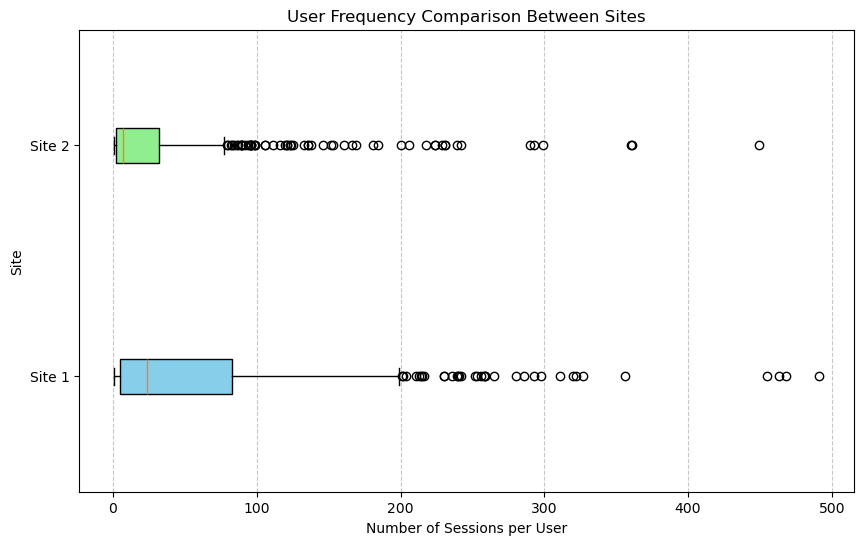

In [55]:
# Group by user ID and count the number of sessions per user
user_frequency_1 = data_1.groupby('userID').size()
user_frequency_2 = data_2.groupby('userID').size()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))


# Create individual boxplots for each site with custom colors
box_data = [user_frequency_1, user_frequency_2]
box_colors = ['skyblue', 'lightgreen']
box_labels = ['Site 1', 'Site 2']

# Draw the boxplots
bp = ax.boxplot(box_data, vert=False, patch_artist=True, labels=box_labels)

# Set custom colors
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)

# Box plot
ax.set_title('User Frequency Comparison Between Sites')
ax.set_xlabel('Number of Sessions per User')
ax.set_ylabel('Site')
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

Site 1 seems to be a private charging station for company employees. The variety of frequent and regular users suggests many employees use it daily. A few users charge particularly often, likely because they commute every day.  
On the other hand, Site 2 appears to be a public charging station at a university. Most users charge their vehicles only occasionally, typical for students or university visitors. A handful of users charge more frequently, but the majority use the station sporadically.

#### **Charging Duration and Energy Consumption**

The goal of this analysis is to determine if charging durations and energy consumption patterns indicate a specific type of location.

This section calculates the charging duration for both datasets. The charging duration is derived by subtracting the connectionTime from the chargingTime and then converting the result from seconds to hours.

In [56]:
# Calculate the charging duration in hours for both datasets
data_1['chargingDuration'] = (data_1['doneChargingTime'] - data_1['connectionTime']).dt.total_seconds() / 3600
data_2['chargingDuration'] = (data_2['doneChargingTime'] - data_2['connectionTime']).dt.total_seconds() / 3600

In this step, summary statistics (mean and median) for the charging duration and kWh delivered are calculated for both sites (siteID=1 and siteID=2).

In [57]:
# Summary for siteID=1
summary_stats_1 = data_1[['chargingDuration', 'kWhDelivered']].agg(['mean', 'median']).reset_index()
summary_stats_1['siteID'] = 1

# Summary for siteID=2
summary_stats_2 = data_2[['chargingDuration', 'kWhDelivered']].agg(['mean', 'median']).reset_index()
summary_stats_2['siteID'] = 2

# Combine the statistics for both sites
summary_stats = pd.concat([summary_stats_1, summary_stats_2])
print("Summary of Charging Duration and Energy Consumption:")
print(summary_stats)


Summary of Charging Duration and Energy Consumption:
    index  chargingDuration  kWhDelivered  siteID
0    mean          4.031188     10.343517       1
1  median          3.498889      8.991000       1
0    mean          2.977065      7.696862       2
1  median          2.047500      6.588000       2


 The goal of these visualizations is to compare the charging duration and energy consumption for the two sites (siteID=1 and siteID=2). The first two plots are boxplots that show the distribution of charging duration and energy delivered for each site, while the last two plots are histograms that provide further insight into the distribution of charging durations and energy consumption.

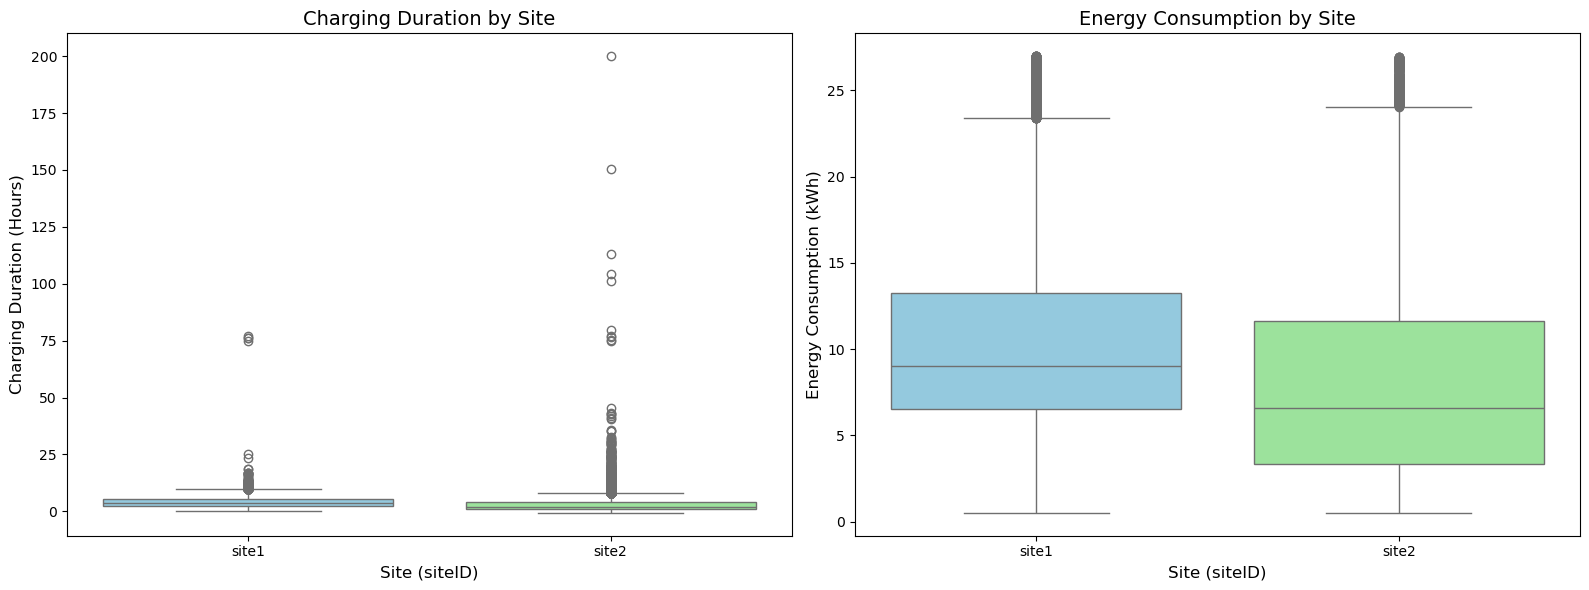

In [58]:
# Define the custom color palette
custom_palette = {'site1': 'skyblue', 'site2': 'lightgreen'}

# Prepare the data with site labels
data_combined = pd.concat([
    data_1.assign(siteID='site1'), 
    data_2.assign(siteID='site2')
])

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Boxplot for charging duration
sns.boxplot(
    data=data_combined, 
    x='siteID', 
    y='chargingDuration', 
    palette=custom_palette, 
    ax=axes[0]
)
axes[0].set_title("Charging Duration by Site", fontsize=14)
axes[0].set_xlabel("Site (siteID)", fontsize=12)
axes[0].set_ylabel("Charging Duration (Hours)", fontsize=12)

# Boxplot for energy consumption
sns.boxplot(
    data=data_combined, 
    x='siteID', 
    y='kWhDelivered', 
    palette=custom_palette, 
    ax=axes[1]
)
axes[1].set_title("Energy Consumption by Site", fontsize=14)
axes[1].set_xlabel("Site (siteID)", fontsize=12)
axes[1].set_ylabel("Energy Consumption (kWh)", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


Key Statistics:

| Metric                      | Site 1         | Site 2         |
|-----------------------------|----------------|----------------|
| Average Charging Duration   | 6.87 hours     | 5.85 hours     |
| Median Charging Duration    | 7.60 hours     | 4.99 hours     |
| Average Energy Consumption  | 14.16 kWh      | 8.81 kWh       |
| Median Energy Consumption   | 11.29 kWh      | 6.59 kWh       |


The boxplot for charging duration reveals that the distribution of charging times at Site 1 is slightly higher and broader than at Site 2. This suggests that vehicles tend to stay connected for longer periods at Site 1, aligning with predictable usage patterns by employees.

The boxplot for energy consumption indicates that both the average and median energy consumption at Site 1 are higher than at Site 2. This could be attributed to longer charging durations and a controlled environment with regular users.

##### Conclusion

The analysis confirms that **site 1 is likely a private charging station**, such as one at a company parking lot, while **site 2 corresponds to a public charging station** near the university.

- Site 1 exhibits predictable weekday usage, longer charging durations, more equal users and higher energy consumption. These patterns align with employees charging their vehicles during fixed working hours in a controlled, private setting.

- Site 2 shows more varied usage across the day and week, shorter charging, higher variety of users, and lower energy consumption. Although the total number of unique registered users is similar to site 1, the significantly higher volume of anonymous, unregistered users reflects the public access and transient visitors typical of a university setting.


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### `Utilization Prediction`

In this analysis, **utilization** refers to the percentage of parking spaces being occupied during a specific time period. It is calculated as the ratio of the **total time used** by the parking spaces to the **total available time** they are open for use.

The formula for utilization is:

$$
Utilization = \frac{Total\ Time\ Used}{Total\ Availability\ Time} \times 100
$$

- **Total Time Used**: The total amount of time during which a parking space was occupied.
- **Total Availability Time**: The total amount of time the parking space was available for use during the analyzed period (e.g., hours in a day, week, or month).

To calculate the **hourly utilization**, we look at each hour of the day and determine how much time a parking space was in use during that hour, relative to the total time the parking space was available during that hour. Since each parking space is available for the full hour, the **availability time** for each hour is the number of parking spaces (e.g., 52 or 54) multiplied by the number of hours (usually 1 hour for each hour of the day).

### Example:
If a parking garage has 52 parking spaces, and during a specific hour, a total of 40 hours of parking usage are recorded (this means 40 parking spaces were occupied for a certain hour), the **Utilization** for that hour would be:

$$
Utilization = \frac{40}{52} \times 100 \approx 76.9\%
$$

This is the hourly utilization calculation for a given time period (such as an hour). High utilization indicates that the parking spaces are in frequent use, while low utilization suggests that many parking spaces remain vacant during that time. Monitoring hourly utilization helps to understand demand trends throughout the day and can assist in optimizing parking management.


The overall goal is to predict the hourly utilization of the two sites. We can calculate this by looking at the connection and disconnection times ofthe EVs parking. We split the sessions into hours to see the utilization for each hour of the day. 


In [59]:
def split_sessions_into_hours(df):
    rows = []
    for _, row in df.iterrows():
        start = row['connectionTime']
        end = row['disconnectTime']
        site_id = row['siteID']
        
        current = start
        while current < end:
            next_hour = (current + pd.Timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
            if next_hour > end:  
                next_hour = end
            
            # calculate duration of current hour
            duration_in_hour = (next_hour - current).total_seconds() / 3600  # Stunden
            
            rows.append({
                'siteID': site_id,
                'hour': current.replace(minute=0, second=0, microsecond=0),
                'connectionTime': start,
                'session_duration_in_hour': duration_in_hour

            })
            
            current = next_hour  
        
    return pd.DataFrame(rows)


In [60]:
hourly_sessions=split_sessions_into_hours(data_unique)

In [61]:
# to see if we made a mistake. logically, the cumulated duration of the siteIDs per hour cannot be more than 52 (54) because this would mean that there are more parking spaces used than available. This df should be empty.
debug_utilization = hourly_sessions.groupby(['siteID', 'hour'])['session_duration_in_hour'].sum()
debug_issues = debug_utilization[debug_utilization > 52].reset_index()
print(debug_issues)

Empty DataFrame
Columns: [siteID, hour, session_duration_in_hour]
Index: []


In [62]:
# cumulate sessions per hour
hourly_utilization = hourly_sessions.groupby(['siteID', 'hour'])['session_duration_in_hour'].sum().reset_index()

# From Preprocessing and further analysis we know, that in siteID 1 there are 52 parking lots and in siteID 2 54.
hourly_utilization['total_availability_time_h'] = hourly_utilization['siteID'].map({1: 52, 2: 54})

# caculate utilization
hourly_utilization['utilization'] = (hourly_utilization['session_duration_in_hour'] / hourly_utilization['total_availability_time_h']) * 100


In [63]:
# Add a column for weekday or weekend
hourly_utilization['is_weekend'] = hourly_utilization['hour'].dt.weekday >= 5  # 5 = Saturday, 6 = Sunday
hourly_utilization['is_weekend'] = hourly_utilization['is_weekend'].replace({True: 1, False: 0})

# Group by weekday/weekend and calculate mean utilization
utilization_by_type = hourly_utilization.groupby(['is_weekend', 'siteID'])['utilization'].describe()
print(utilization_by_type)

# Average hourly utilization for weekdays and weekends
hourly_trends = hourly_utilization.groupby([hourly_utilization['hour'].dt.hour, 'siteID', 'is_weekend'])['utilization'].mean().reset_index()
print(hourly_trends)

                     count       mean        std       min       25%  \
is_weekend siteID                                                      
0          1       12370.0  33.069316  36.105488  0.001068  3.846154   
           2       13864.0  20.027184  21.924783  0.004630  3.703704   
1          1        2683.0   3.127022   2.940573  0.000534  1.923077   
           2        5438.0   7.396806   7.102291  0.001543  1.851852   

                         50%        75%         max  
is_weekend siteID                                    
0          1       16.165064  59.558093  100.000000  
           2        9.698817  33.856224   93.286523  
1          1        1.923077   3.846154   38.238782  
           2        4.335391  10.751286   41.793210  
    hour  siteID  is_weekend  utilization
0      0       1           0     2.359927
1      0       1           1     2.276154
2      0       2           0     6.024808
3      0       2           1     6.260018
4      1       1           0     

There are days where the utilization is 100%. So every parking space is used.

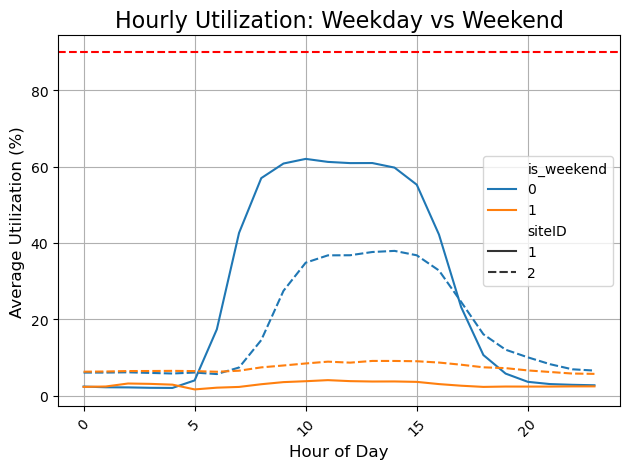

In [64]:
# plot for hourly average utilization
sns.lineplot(data=hourly_trends, x='hour', y='utilization', hue='is_weekend', style='siteID', legend='auto', dashes=True)

plt.title('Hourly Utilization: Weekday vs Weekend', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Utilization (%)', fontsize=12)
plt.axhline(90, color='red', linestyle='--', label='90% Threshold')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To visualize the utilization on specific days for analysis. There are some days where the utilization is very low and others, where the utilization is nearly maximized. The average is therefore not as high as expected. But by looking at individual days we can see the different utilization types.

In [65]:
import locale
def plot_daily_utilization(data, date):
    """
    Plot the hourly utilization for a given day and highlight when it exceeds 90%.
    
    Parameters:
    - data: Pandas DataFrame containing 'hour', 'utilization', and a datetime column.
    - date: The specific date to filter (format: 'YYYY-MM-DD').
    """
    
    # Filter for the specific day
    daily_data = data[data['hour'].dt.date == pd.to_datetime(date).date()]
    
    if daily_data.empty:
        print(f"No data available for {date}.")
        return
    
    # set the locale to English to get weekdays in englisch
    locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
    weekday = pd.to_datetime(date).strftime('%A')
    
    plt.figure(figsize=(12, 6))

    # Loop through each siteID to plot separately
    for site in daily_data['siteID'].unique():
        site_data = daily_data[daily_data['siteID'] == site]
        
        # Plot hourly utilization for the site
        plt.plot(site_data['hour'], site_data['utilization'], label=f'Site {site}', marker='o')
        
        # Highlight hours where utilization exceeds 90% for this site
        over_90 = site_data[site_data['utilization'] > 90]
        plt.scatter(over_90['hour'], over_90['utilization'], color='red', label=f'Site {site} >90% Utilization', zorder=5)

    # Customize plot
    plt.title(f'Hourly Utilization for {date} ({weekday})', fontsize=16)
    plt.xlabel('Hour', fontsize=12)
    plt.ylabel('Utilization (%)', fontsize=12)
    
    # 90% Threshold Line
    plt.axhline(90, color='red', linestyle='--', label='90% Threshold')
    
    # Display the legend
    plt.legend(loc='upper left', fontsize=10)
    
    # Format the plot
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


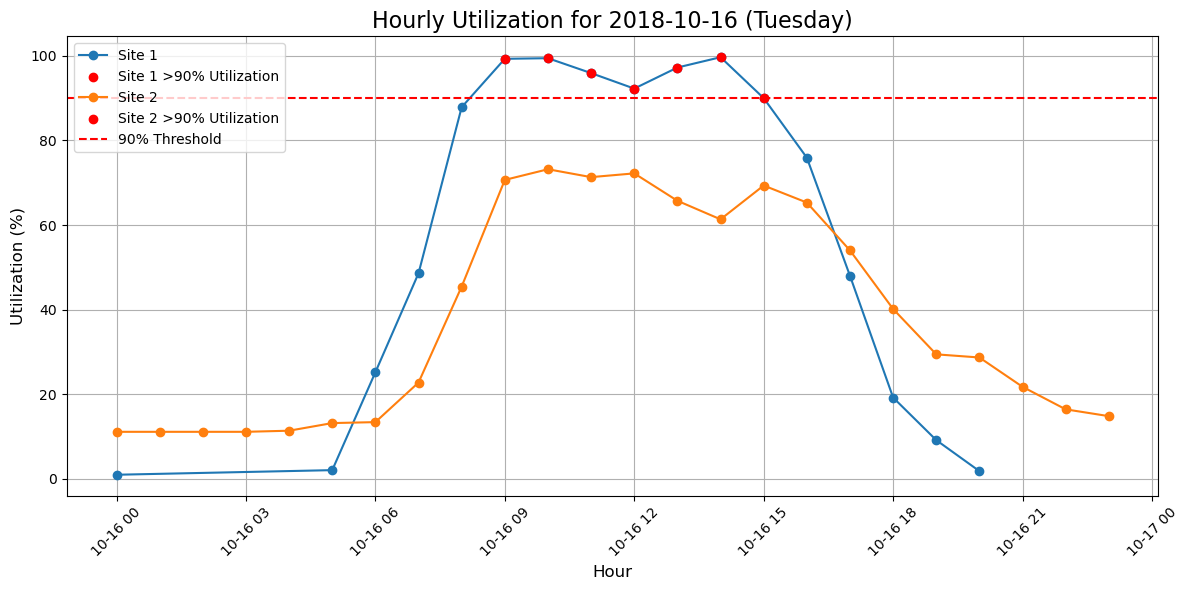

In [66]:
# Example: Plot utilization for Oktober 16th 2018
plot_daily_utilization(hourly_utilization, '2018-10-16')

We need to have a look at the siteIDs themselves when predicting.

In [67]:
utilization_1 = hourly_utilization[hourly_utilization['siteID']==1]
utilization_2 = hourly_utilization[hourly_utilization['siteID']==2]

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

utilization_1.head()
X = utilization_1[['is_weekend', 'hour', ]]

#we need to convert hour into a numeric datatype (it still is datetime64)
X['hour'] = X['hour'].dt.hour

#add certain day of the week
X['day_of_week'] = utilization_1['hour'].dt.dayofweek

y = utilization_1['utilization']

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

scaler = StandardScaler()

#RandomForest as model
model = RandomForestRegressor(random_state=50)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate the Model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared Score:", r2_score(y_test, y_pred))

Mean Squared Error: 520.1706680558236
R-squared Score: 0.5841574854373597


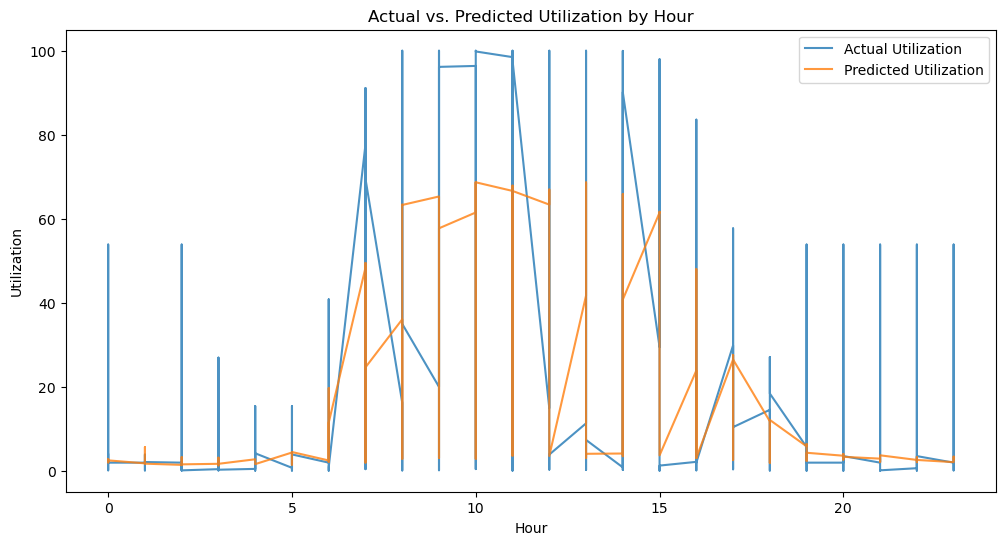

In [69]:
# Combine actual and predicted values with the test features for visualization
results = X_test.copy()
results['Actual Utilization'] = y_test.values
results['Predicted Utilization'] = y_pred

# Sort by hour for better trend visualization
results = results.sort_values(by='hour')

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(results['hour'], results['Actual Utilization'], label='Actual Utilization', alpha=0.8)
plt.plot(results['hour'], results['Predicted Utilization'], label='Predicted Utilization', alpha=0.8)
plt.xlabel('Hour')
plt.ylabel('Utilization')
plt.title('Actual vs. Predicted Utilization by Hour')
plt.legend()
plt.show()


The model performance is really bad (see errors) and the prediction really underfits the true values. The utilization is much lower predicted than in truth.

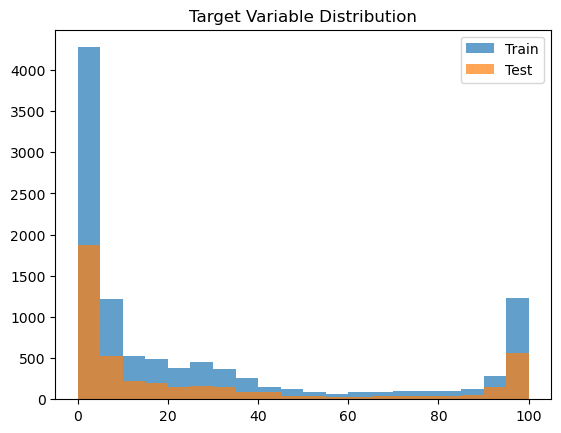

In [70]:
#Analyze target varaible to see the distribution:
plt.hist(y_train, bins=20, alpha=0.7, label='Train')
plt.hist(y_test, bins=20, alpha=0.7, label='Test')
plt.legend()
plt.title("Target Variable Distribution")
plt.show()

We have to make sum assumptions to our model. The performance of the first try is really bad so we have to improve our input features. We add the information about the certain day of the week (`day_of_week`) to improve the prediction.   
Our time-related data (`hour`and `day_of_week`) also need some preprocessing. Time and dates (date information) are cyclic data which means we need to show the model that 23:59 is very close to 00:00 because the clock is ticking in a circle. We then don't need the `hour`and `day_of_week`anymore, because we store them in the sin and cos columns.  
To better see how the utilization varies on weekends and weekdays during the day we add an intersection term. This term has presumably a high influence on the prediction.

We use GridSearchCV to do some hyperparameter tuning. GridSearchCV tries all the combinations of the values passed in the dictionary and evaluates the model for each combination using the Cross-Validation method to find the best fitting hyperparameters.

Make the prediction for site 2 - for site 1 use utilization_1 --> maybe make a function?

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Mean Squared Error: 6.84546182922072
R-squared Score: 0.9817514134246773


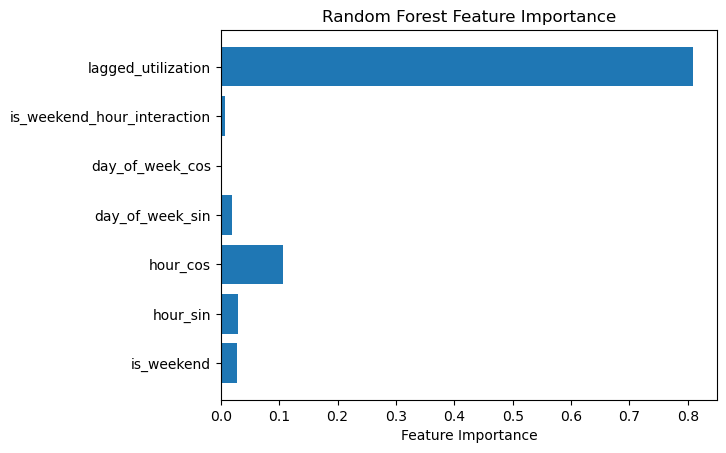

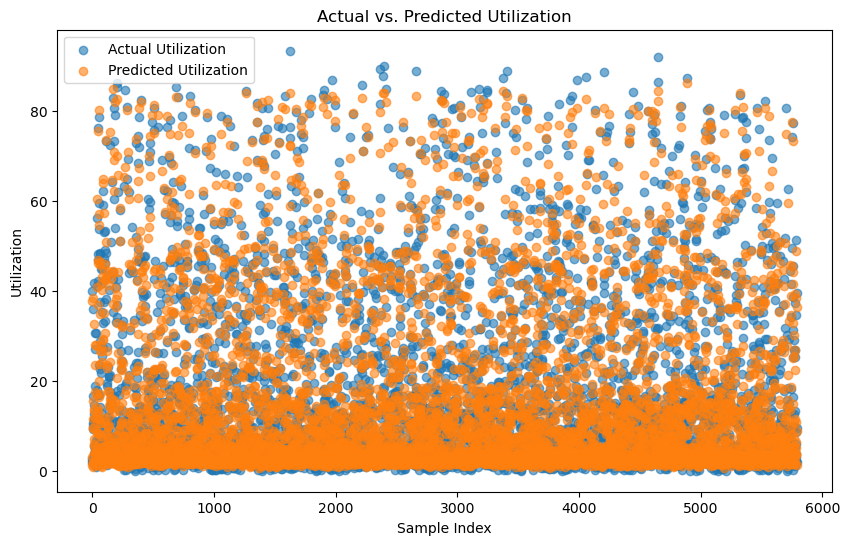

In [71]:
# Necessary imports for model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#just predict for siteID=1
X = utilization_2[['is_weekend', 'hour']]
y = utilization_2['utilization']

X['hour'] = X['hour'].dt.hour

# Add 'day_of_week' feature
X['day_of_week'] = utilization_2['hour'].dt.dayofweek

#use sin and cos for the hours and days to represent the cyclic data
# sin(2 * pi * x / max_value)
# cos(2 * pi * x / max_value) 
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
X['day_of_week_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 7)
X['day_of_week_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 7)

X = X.drop(['hour', 'day_of_week'], axis=1)

# Add interaction terms to see how the utilization varies on weekends and weekdays during the day
X['is_weekend_hour_interaction'] = X['is_weekend'] * X['hour_sin']

# Add lagged utilization as a feature to learn the model about the prediction of previous hour
utilization_2['lagged_utilization'] = utilization_2['utilization'].shift(1).fillna(0)
X['lagged_utilization'] = utilization_2[utilization_2['siteID'] == 2]['lagged_utilization']

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Log-transform the target variable to handle skewness
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Tune hyperparameters for Random Forest using GridSearchCV to find best parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1)

#foítting the model for grid search
grid_search.fit(X_train_scaled, y_train_log)

# Use the best model from GridSearchCV
best_model = grid_search.best_estimator_
print(grid_search.best_params_)

# Make predictions
y_pred_log = best_model.predict(X_test_scaled)

# Reverse log transformation for predictions
y_pred = np.expm1(y_pred_log)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Plot Feature Importance
importances = best_model.feature_importances_
feature_names = X.columns
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# Plot Actual vs Predicted Utilization
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual Utilization", alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted Utilization", alpha=0.6)
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Utilization")
plt.title("Actual vs. Predicted Utilization")
plt.show()


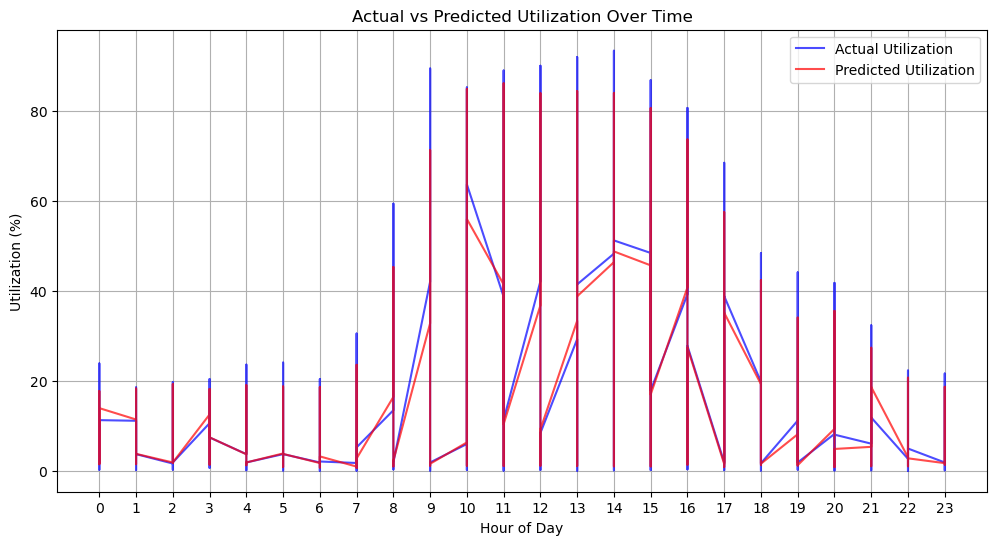

In [72]:
# Recover the actual hour from the sin and cos values
X_test['hour_reconstructed'] = (np.arctan2(X_test['hour_sin'], X_test['hour_cos']) * 24 / (2 * np.pi)) % 24

# Create a dataframe to compare actual vs predicted values along with the hour
results_df = pd.DataFrame({
    'hour': X_test['hour_reconstructed'],  # Use the 'hour' column from X_test
    'actual': y_test,        # Actual utilization values
    'predicted': y_pred      # Predicted utilization values
})

# Sort by hour for better visualization
results_df = results_df.sort_values(by='hour')

# Plot actual vs predicted utilization over time (hourly)
plt.figure(figsize=(12, 6))
plt.plot(results_df['hour'], results_df['actual'], label="Actual Utilization", color='blue', alpha=0.7)
plt.plot(results_df['hour'], results_df['predicted'], label="Predicted Utilization", color='red', alpha=0.7)
plt.xlabel("Hour of Day")
plt.ylabel("Utilization (%)")
plt.title("Actual vs Predicted Utilization Over Time")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # Show each hour of the day on x-axis
plt.show()


In [73]:
X_test.head(10)

,is_weekend,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,is_weekend_hour_interaction,lagged_utilization,hour_reconstructed
25582,0,-0.500000,8.660254e-01,0.781831,0.623490,-0.000000,3.703704,22.0
30414,0,0.707107,7.071068e-01,0.433884,-0.900969,0.000000,1.219650,3.0
27213,0,-0.866025,-5.000000e-01,0.433884,-0.900969,-0.000000,43.389918,16.0
18006,1,0.965926,2.588190e-01,-0.781831,0.623490,0.965926,16.618827,5.0
30923,0,0.965926,2.588190e-01,0.000000,1.000000,0.000000,1.851852,5.0
26527,0,-0.965926,2.588190e-01,-0.433884,-0.900969,-0.000000,17.992284,19.0
16783,0,1.000000,6.123234e-17,-0.433884,-0.900969,0.000000,9.259259,6.0
27366,0,-0.707107,-7.071068e-01,0.433884,-0.900969,-0.000000,35.893519,15.0
29904,0,0.965926,-2.588190e-01,0.433884,-0.900969,0.000000,1.366255,7.0
30416,0,0.965926,2.588190e-01,0.433884,-0.900969,0.000000,1.851852,5.0


Polynomaial Regression Model: does not perform well, not good fit, improvement needed

In [74]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = utilization_1[['is_weekend', 'hour', 'siteID']].copy()
X['hour'] = X['hour'].dt.hour  # Convert hour to numerical
y = utilization_1['utilization']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=10, include_bias=False)  # Degree 2 for quadratic terms
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit a Linear Regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions
y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 585.3191555756362
R-squared Score: 0.5262290449188898


The higher the polynomial degree, the better. We need function with a kind of wide, flat plateau as a high point. Maybe there is a plateau function?

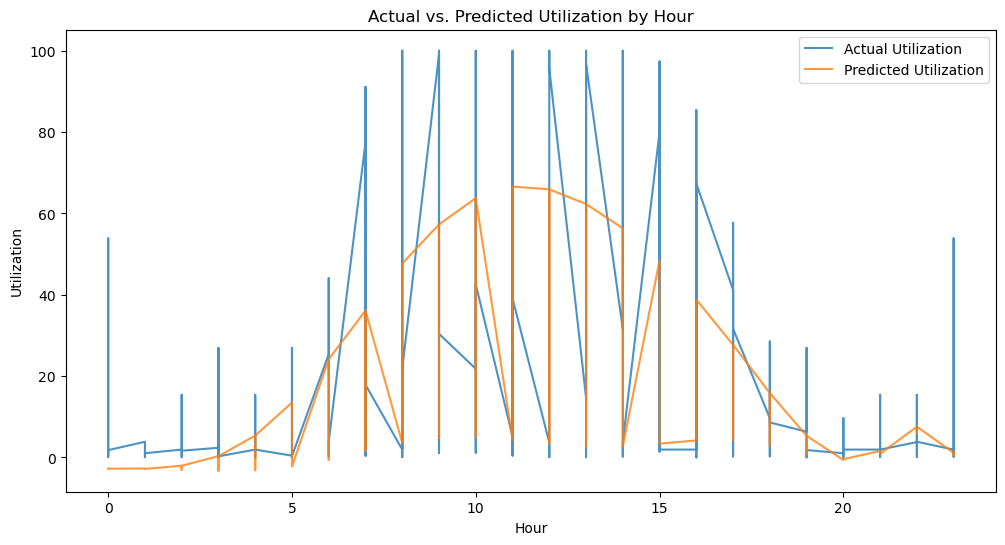

In [75]:
# Combine actual and predicted values with the test features for visualization
results = X_test.copy()
results['Actual Utilization'] = y_test.values
results['Predicted Utilization'] = y_pred

# Sort by hour for better trend visualization
results = results.sort_values(by='hour')

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(results['hour'], results['Actual Utilization'], label='Actual Utilization', alpha=0.8)
plt.plot(results['hour'], results['Predicted Utilization'], label='Predicted Utilization', alpha=0.8)
plt.xlabel('Hour')
plt.ylabel('Utilization')
plt.title('Actual vs. Predicted Utilization by Hour')
plt.legend()
plt.show()

Just an example for a polynomial regression to see how it works:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Example data
X = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).reshape(-1, 1)
y = np.array([2, 3, 5, 6, 6.5, 6.6, 6.7, 6.8, 6.9, 7])  # Plateau behavior

# Create polynomial features
poly = PolynomialFeatures(degree=4)  # Adjust degree as needed
X_poly = poly.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train a Ridge regression model
ridge_reg = Ridge(alpha=5.0)  # alpha is the regularization parameter
ridge_reg.fit(X_train, y_train)

# Make predictions
y_pred = ridge_reg.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.16562484833048635
R-squared Score: 0.9564431694068412


In [92]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [106]:
import keras
from keras import Sequential # sequential model: https://keras.io/guides/sequential_model/
from keras.layers import Dense, Dropout

In [127]:

# Extract features and target variable
X = utilization_1[['is_weekend', 'hour']]
y = utilization_1['utilization']

# Add 'day_of_week' feature
X['hour'] = X['hour'].dt.hour
X['day_of_week'] = utilization_1['hour'].dt.dayofweek

# Add cyclic features for 'hour' and 'day_of_week'
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
X['day_of_week_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 7)
X['day_of_week_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 7)

# Drop original 'hour' and 'day_of_week'
X = X.drop(['hour', 'day_of_week'], axis=1)

# Add interaction terms
X['is_weekend_hour_interaction'] = X['is_weekend'] * X['hour_sin']

# Add lagged utilization
utilization_1['lagged_utilization'] = utilization_1['utilization'].shift(1).fillna(0)
X['lagged_utilization'] = utilization_1['lagged_utilization']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features: just normalize training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [128]:
#initializig artificial neural network

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(rate=0.2),
    Dense(32, activation='relu'),
    Dropout(rate=0.2),
    Dense(1, activation='linear')  # Output layer for regression
])

In [129]:
#compiling the ANN
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

In [130]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

In [136]:
#train the model
history = model.fit(
    X_train_scaled, y_train_log,
    validation_data=(X_test_scaled, y_test_log),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1411 - mae: 0.2825 - mse: 0.1411 - val_loss: 0.1022 - val_mae: 0.2229 - val_mse: 0.1022
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1413 - mae: 0.2834 - mse: 0.1413 - val_loss: 0.0941 - val_mae: 0.2008 - val_mse: 0.0941
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1389 - mae: 0.2854 - mse: 0.1389 - val_loss: 0.0911 - val_mae: 0.2050 - val_mse: 0.0911
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1430 - mae: 0.2850 - mse: 0.1430 - val_loss: 0.0911 - val_mae: 0.1995 - val_mse: 0.0911
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1338 - mae: 0.2752 - mse: 0.1338 - val_loss: 0.0975 - val_mae: 0.2293 - val_mse: 0.0975
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1403 - mae: 0.2830 - mse: 0.1403 - val_loss: 0.0890 - val_mae: 0.2008 - val_mse: 0.0890
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1386 - mae: 0.2798 - mse:

In [137]:
history_df = pd.DataFrame(history.history)
history_df.head()
root_metrics_df = history_df[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_df.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
root_metrics_df

,rmse,val_rmse
0,0.377061,0.319708
1,0.377199,0.306803
2,0.376219,0.301847
3,0.376931,0.301804
4,0.375454,0.312289
...,...,...
95,0.366672,0.316783
96,0.364069,0.302613
97,0.362975,0.301792
98,0.367522,0.301344


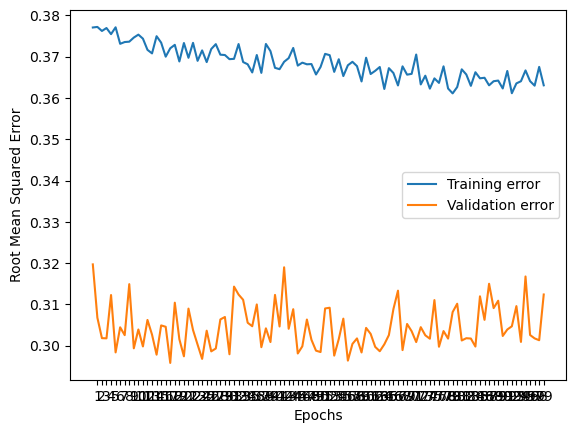

In [139]:
plt.Figure(figsize=(14,6), dpi=100)

plt.plot(root_metrics_df["rmse"], label = 'Training error')
plt.plot(root_metrics_df["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

# plt.xlim([0, epochs])
plt.xticks(range(1,100))
plt.legend()

plt.show()

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network - Mean Squared Error: 15.662182805711
Neural Network - R-squared Score: 0.9872815777355499


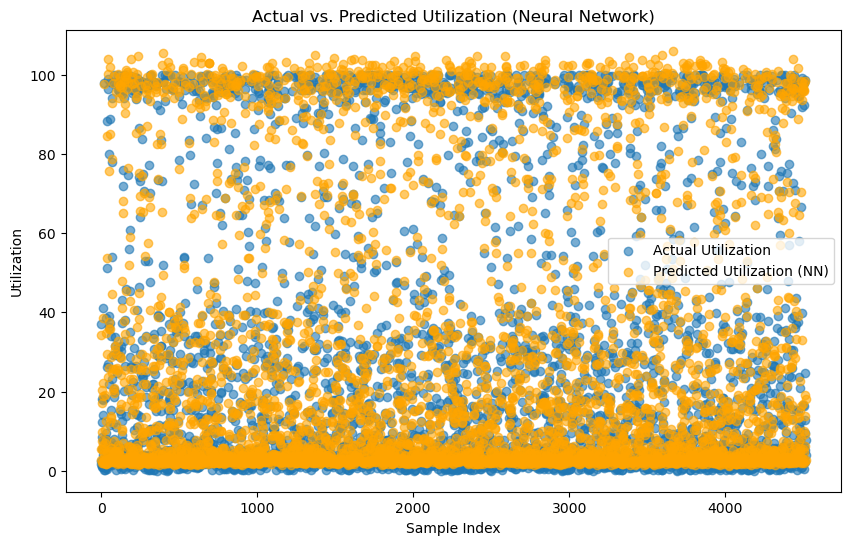

In [140]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred_log_nn = model.predict(X_test_scaled)
y_pred_nn = np.expm1(y_pred_log_nn)  # Reverse log transformation

# Evaluate the model
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print("Neural Network - Mean Squared Error:", mse_nn)
print("Neural Network - R-squared Score:", r2_nn)

# Plot Actual vs Predicted Utilization
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual Utilization", alpha=0.6)
plt.scatter(range(len(y_pred_nn)), y_pred_nn, label="Predicted Utilization (NN)", alpha=0.6, color='orange')
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Utilization")
plt.title("Actual vs. Predicted Utilization (Neural Network)")
plt.show()
